<a href="https://colab.research.google.com/github/PROACT-team/2023-Loss-of-autonomy-in-swallowing/blob/main/3_Model_Construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install scikit-survival==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.6 MB/s eta 0:00:00


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
# Read datasets needed (if using local files)
from google.colab import files
uploaded = files.upload()

In [ ]:
# Read datasets needed (if using local files)
import io
feature_and_target = pd.read_csv(io.BytesIO(uploaded['X_and_Y_with_NaNs.csv']))

In [ ]:
# Read datasets needed (if using google drive)
feature_and_target = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Files/X_and_Y_with_NaNs.csv')

In [ ]:
feature_and_target.drop(['Unnamed: 0', 'SubjectID'], axis = 1, inplace = True)
feature_and_target

Age  Gender  diag_delta  onset_delta  onset_site  diag_minus_onset  \
0      7.0       0        9.93        16.47           0             -6.54   
1     10.0       0        1.45        33.63           1            -32.18   
2     12.0       0        1.61        16.90           0            -15.29   
3      5.0       1       16.80        18.74           0             -1.94   
4      8.0       0       12.43        25.08           0            -12.65   
...    ...     ...         ...          ...         ...               ...   
2665   7.0       1        6.15        29.16           0            -23.01   
2666   6.0       0        0.69        19.43           0            -18.74   
2667   9.0       1        1.61        32.84           1            -31.23   
2668   7.0       1        2.76        16.18           0            -13.42   
2669   8.0       0        8.88        10.88           0             -2.00   

      mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
0           4.000000            4.000000            4.000000   
1           1.000000            1.333333            2.000000   
2           4.000000            3.750000            3.250000   
3           2.500000            3.000000            3.000000   
4           4.000000            4.000000            4.000000   
...              ...                 ...                 ...   
2665        4.000000            4.000000            4.000000   
2666        1.666667            2.000000            2.666667   
2667        3.000000            3.000000            4.000000   
2668        2.750000            3.000000            2.750000   
2669        3.000000            4.000000            4.000000   

      mean_Q4_Handwriting  ...  slope_bulbar  slope_motor    mean_fvc  \
0                3.500000  ...      0.000000    -0.293851         NaN   
1                4.000000  ...     -0.492045     0.770871   73.443432   
2                4.000000  ...      0.326087    -1.195652   89.625247   
3                1.500000  ...     -0.632911    -1.898734   71.333333   
4                4.000000  ...           NaN          NaN   86.046552   
...                   ...  ...           ...          ...         ...   
2665             4.000000  ...      0.000000    -1.030016   90.979381   
2666             4.000000  ...      0.022299     0.022299   85.780886   
2667             4.000000  ...           NaN          NaN   74.934731   
2668             4.000000  ...     -0.654804    -0.120494  100.794603   
2669             0.666667  ...      0.000000    -1.624528   84.856712   

      slope_fvc  mean_Creatinine  slope_Creatinine  mean_weight  slope_weight  \
0           NaN            53.04          0.000000   120.033333      1.979045   
1           NaN            79.56               NaN    51.000000     -0.228993   
2     -1.132206              NaN               NaN    62.220000           NaN   
3      0.000000            58.40         -0.703942   121.400000           NaN   
4           NaN            53.04               NaN    88.900000     -1.500000   
...         ...              ...               ...          ...           ...   
2665  -0.931190            55.70               NaN    85.000000           NaN   
2666  -4.990745            53.00               NaN    57.900000           NaN   
2667        NaN            83.98          5.854305    84.750000           NaN   
2668  -0.622381              NaN               NaN    70.460000           NaN   
2669   0.153161            48.62               NaN    56.720000     -0.031719   

      time_LOA  status_LOA  
0        10.18         0.0  
1         6.44         1.0  
2         2.06         0.0  
3         5.02         1.0  
4         9.43         0.0  
...        ...         ...  
2665      3.12         0.0  
2666      3.08         0.0  
2667      9.82         0.0  
2668      3.05         0.0  
2669      1.14         0.0  

[2670 rows x 46 columns]

In [ ]:
# Check the proportion of censored data
event_distribution = pd.DataFrame(feature_and_target[['status_LOA']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)   # 2093 censored, 577 uncensored  (78% censored)

         status  count
0  0 (censored)   2093
1   1 (occured)    577


# 0. Data Imputation for feature selection

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
# Drop features with NaN proportion > 40% : ['slope_fvc', 'slope_Creatinine', 'slope_weight'] is excluded
X_y_NaN = feature_and_target.copy()
X_y_NaN.drop(['slope_fvc', 'slope_Creatinine', 'slope_weight'], axis=1, inplace=True)

In [ ]:
# Imputation with IterativeImputer
y = X_y_NaN[['time_LOA', 'status_LOA']]
X_NaN = X_y_NaN.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_imputed = pd.concat([X_imputed, y],axis=1)
X_y_imputed

Age  Gender  diag_delta  onset_delta  onset_site  diag_minus_onset  \
0      7.0     0.0        9.93        16.47         0.0             -6.54   
1     10.0     0.0        1.45        33.63         1.0            -32.18   
2     12.0     0.0        1.61        16.90         0.0            -15.29   
3      5.0     1.0       16.80        18.74         0.0             -1.94   
4      8.0     0.0       12.43        25.08         0.0            -12.65   
...    ...     ...         ...          ...         ...               ...   
2665   7.0     1.0        6.15        29.16         0.0            -23.01   
2666   6.0     0.0        0.69        19.43         0.0            -18.74   
2667   9.0     1.0        1.61        32.84         1.0            -31.23   
2668   7.0     1.0        2.76        16.18         0.0            -13.42   
2669   8.0     0.0        8.88        10.88         0.0             -2.00   

      mean_Q1_Speech  mean_Q2_Salivation  mean_Q3_Swallowing  \
0           4.000000            4.000000            4.000000   
1           1.000000            1.333333            2.000000   
2           4.000000            3.750000            3.250000   
3           2.500000            3.000000            3.000000   
4           4.000000            4.000000            4.000000   
...              ...                 ...                 ...   
2665        4.000000            4.000000            4.000000   
2666        1.666667            2.000000            2.666667   
2667        3.000000            3.000000            4.000000   
2668        2.750000            3.000000            2.750000   
2669        3.000000            4.000000            4.000000   

      mean_Q4_Handwriting  ...  slope_R3_Respiratory_Insufficiency  \
0                3.500000  ...                            0.000000   
1                4.000000  ...                            0.000000   
2                4.000000  ...                            0.000000   
3                1.500000  ...                            0.000000   
4                4.000000  ...                           -0.016799   
...                   ...  ...                                 ...   
2665             4.000000  ...                            0.000000   
2666             4.000000  ...                            0.000000   
2667             4.000000  ...                           -0.016895   
2668             4.000000  ...                            0.000000   
2669             0.666667  ...                            0.000000   

      slope_ALSFRS_R_Total  slope_respiratory_R  slope_bulbar  slope_motor  \
0                -0.293851             0.000000      0.000000    -0.293851   
1                 0.065606             0.000000     -0.492045     0.770871   
2                -1.195652            -0.434783      0.326087    -1.195652   
3                -3.164557             0.632911     -0.632911    -1.898734   
4                -0.828628            -0.114962     -0.073397    -0.601339   
...                    ...                  ...           ...          ...   
2665             -1.030016             0.000000      0.000000    -1.030016   
2666              0.044598             0.000000      0.022299     0.022299   
2667             -0.828471            -0.114962     -0.073274    -0.601243   
2668             -0.775298             0.000000     -0.654804    -0.120494   
2669             -2.164089            -0.539561      0.000000    -1.624528   

        mean_fvc  mean_Creatinine  mean_weight  time_LOA  status_LOA  
0      98.098266        53.040000   120.033333     10.18         0.0  
1      73.443432        79.560000    51.000000      6.44         1.0  
2      89.625247        46.250901    62.220000      2.06         0.0  
3      71.333333        58.400000   121.400000      5.02         1.0  
4      86.046552        53.040000    88.900000      9.43         0.0  
...          ...              ...          ...       ...         ...  
2665   90.979381        55.700000    8

In [ ]:
df_for_featsel = X_y_imputed.copy()

# 1.  Embedded method

In [ ]:
pip install lifelines

##1-1. AFT

### (1) Hyperparameter tuning with GridSearchCV

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

aft_params ={ 'penalizer': [1e-4, 0.00005, 1e-3, 0.005, 1e-2, 0.05, 0.1, 0.15, 0.2, 0.35,0.5],
              'l1_ratio' : [1]  }

In [ ]:
# CAUTION! Runtime takes more than 5mins
from lifelines import WeibullAFTFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_aft = df_for_featsel.drop(columns = 'time_LOA')
y_aft = df_for_featsel['time_LOA']

base_class2 = sklearn_adapter(WeibullAFTFitter, event_col = 'status_LOA')
aft = base_class2()

grid_cv1 = GridSearchCV(aft, param_grid = aft_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv1.fit(X_aft, y_aft)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advis

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnWeibullAFTFitter(alpha=0.05, fit_intercept=True,
                                               l1_ratio=0.0,
                                               model_ancillary=False,
                                               penalizer=0.0),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 5e-05, 0.001, 0.005, 0.01, 0.05,
                                       0.1, 0.15, 0.2, 0.35, 0.5]})

In [ ]:
# Result
print(grid_cv1.best_score_)  # 0.8417957530121799
print(grid_cv1.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01} is selected

0.8417957530121799
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Result
cv_results = grid_cv1.cv_results_
cv_results

{'mean_fit_time': array([1.52344426, 1.59916568, 1.62965178, 1.56863999, 2.3135879 ,
        3.16033268, 5.63667258, 4.88591806, 8.41081929, 3.90728331,
        4.13047489]),
 'std_fit_time': array([0.12869207, 0.30261205, 0.4823814 , 0.34411474, 0.64107323,
        0.75472963, 2.51606525, 1.15095631, 3.42120487, 2.18015934,
        1.13757298]),
 'mean_score_time': array([0.01468261, 0.0193305 , 0.01440064, 0.01512965, 0.01449649,
        0.        , 0.0048755 , 0.01721938, 0.01407536, 0.00980671,
        0.01450253]),
 'std_score_time': array([0.00040024, 0.0065172 , 0.00033569, 0.00101765, 0.00013666,
        0.        , 0.006895  , 0.01525945, 0.01990556, 0.00693537,
        0.00055918]),
 'param_l1_ratio': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalizer': masked_array(data=[0.0001, 5e-05, 0.

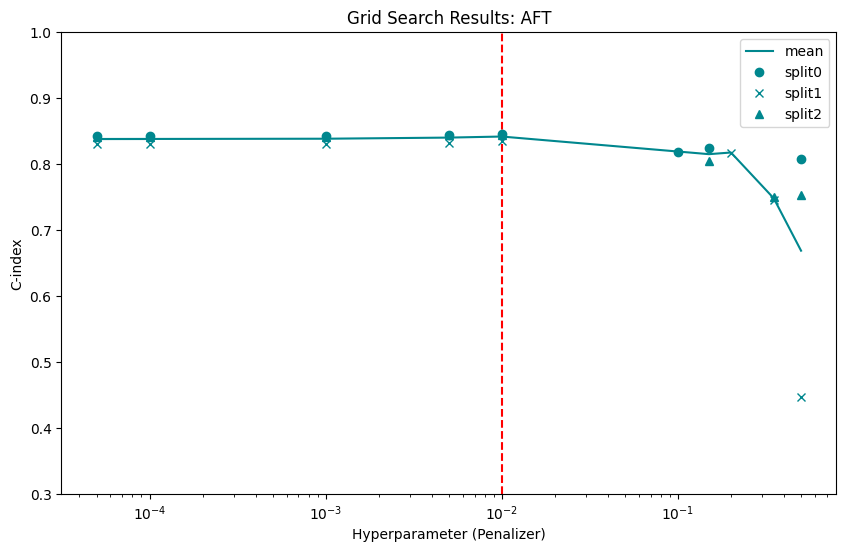

In [ ]:
# Plot the results
cv_results = grid_cv1.cv_results_
cv_results['param_penalizer'] = np.asarray(cv_results['param_penalizer'])

# remove NaN values
valid0 =  ~np.isnan(cv_results['split0_test_score'])
valid1 =  ~np.isnan(cv_results['split1_test_score'])
valid2 =  ~np.isnan(cv_results['split2_test_score'])


fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(x=0.01, color='red', linestyle='--')  # penalizer = 0.01 showed best score
ax.plot(pd.DataFrame(cv_results)[['param_penalizer']].drop(index=5), pd.DataFrame(cv_results)[['split0_test_score', 'split1_test_score', 'split2_test_score']].mean(axis=1, skipna=True).drop(index=5), '-', label='mean', color='#00878E')
#drop(index=5) is because penalizer=0.05 showed NaN value in all cases
ax.plot(cv_results['param_penalizer'][valid0], cv_results['split0_test_score'][valid0], 'o', label='split0', color='#00878E')
ax.plot(cv_results['param_penalizer'][valid1], cv_results['split1_test_score'][valid1], 'x', label='split1', color='#00878E')
ax.plot(cv_results['param_penalizer'][valid2], cv_results['split2_test_score'][valid2], '^', label='split2', color='#00878E')

ax.set_xscale('log')
ax.set_xlabel('Hyperparameter (Penalizer)')
ax.set_ylabel('C-index')
ax.set_title('Grid Search Results: AFT')
plt.ylim([0.3, 1.0])
plt.legend()
plt.show()

### (2) Feature selection with Lasso

In [ ]:
# Fit model with selected hyperparameter & print summary
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel, duration_col='time_LOA', event_col='status_LOA', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 2670 total observations, 2093 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
   number of observations = 2670
number of events observed = 577
           log-likelihood = -2338.09
         time fit was run = 2023-10-30 09:49:51 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                 -0.07       0.93       0.01            -0.10            -0.05                 0.91                 0.95
        Gender                              -0.00       1.00       0.07            -0.15             0.15                 0.86                 1.16
        diag_delta                           0.01       1.01        NaN              NaN              NaN                  NaN                  NaN
        diag_minus_onset                    -0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_ALSFRS_R_Total                  0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Creatinine                      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
        mean_Q1_Speech                       0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q2_Salivation                   0.08       1.08        NaN              NaN              NaN                  NaN                  NaN
        mean_Q3_Swallowing                   0.19       1.21        NaN              NaN              NaN                  NaN                  NaN
        mean_Q4_Handwriting                  0.01       1.01        NaN              NaN              NaN                  NaN                  NaN
        mean_Q5_Cutting                      0.04       1.04        NaN              NaN              NaN                  NaN                  NaN
        mean_Q6_Dressing_and_Hygiene         0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q7_Turning_in_Bed               0.06       1.06        NaN              NaN              NaN                  NaN                  NaN
        mean_Q8_Walking                      0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_Q9_Climbing_Stairs              0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_R1_Dyspnea                     -0.02       0.98        NaN              NaN              NaN                  NaN                  NaN
        mean_R2_Orthopnea                   -0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_R3_Respiratory_Insufficiency   -0.05       0.95        NaN              NaN              NaN                  NaN                  NaN
        mean_bulbar                          0.26       1.30  187931.67       -368339.04        368339.57                 0.00                  inf
        mean_fvc                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
        mean_motor                           0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_respiratory_R                  -0.00       1.00        NaN              NaN              NaN                  NaN                  NaN
        mean_weight                          0.00       1.00       0.00     

In [ ]:
# Print coefficients in order of size
aft_coef = aft.params_.copy()
aft_coef.index = aft_coef.index.droplevel()
df_aft_coef = pd.DataFrame(aft_coef, columns=['coefficient'])
df_aft_coef.reset_index(inplace=True)
df_aft_coef= df_aft_coef.query('covariate != "Intercept"')
df_aft_coef.sort_values(by='coefficient', ascending=True, inplace=True)
df_aft_coef

covariate   coefficient
24                          onset_site -1.311885e-01
0                                  Age -7.235642e-02
17   mean_R3_Respiratory_Insufficiency -5.283275e-02
15                     mean_R1_Dyspnea -2.237295e-02
32             slope_Q7_Turning_in_Bed -2.763817e-06
21                  mean_respiratory_R -2.476922e-06
30                    slope_Q5_Cutting -1.360661e-06
34            slope_Q9_Climbing_Stairs -1.003333e-06
16                   mean_R2_Orthopnea -3.803915e-07
1                               Gender -1.282317e-07
3                     diag_minus_onset -2.390576e-08
13                     mean_Q8_Walking  2.257514e-08
4                  mean_ALSFRS_R_Total  4.861661e-08
36                  slope_R2_Orthopnea  1.853121e-07
6                       mean_Q1_Speech  2.441436e-07
14             mean_Q9_Climbing_Stairs  5.974666e-07
20                          mean_motor  9.338760e-07
11        mean_Q6_Dressing_and_Hygiene  2.136733e-06
38                        slope_bulbar  2.562646e-06
28                 slope_Q3_Swallowing  2.647822e-06
29                slope_Q4_Handwriting  7.073831e-06
39                         slope_motor  7.785954e-06
40                 slope_respiratory_R  1.194167e-05
35                    slope_R1_Dyspnea  1.328666e-05
22                         mean_weight  1.870463e-03
5                      mean_Creatinine  4.053530e-03
2                           diag_delta  5.678447e-03
19                            mean_fvc  6.566159e-03
9                  mean_Q4_Handwriting  1.170643e-02
23                         onset_delta  2.037076e-02
10                     mean_Q5_Cutting  3.683951e-02
25                slope_ALSFRS_R_Total  6.051872e-02
12              mean_Q7_Turning_in_Bed  6.212008e-02
7                   mean_Q2_Salivation  7.917956e-02
27                 slope_Q2_Salivation  1.101612e-01
37  slope_R3_Respiratory_Insufficiency  1.141295e-01
33                    slope_Q8_Walking  1.222560e-01
26                     slope_Q1_Speech  1.516108e-01
8                   mean_Q3_Swallowing  1.869807e-01
31       slope_Q6_Dressing_and_Hygiene  2.560762e-01
18                         mean_bulbar  2.636564e-01

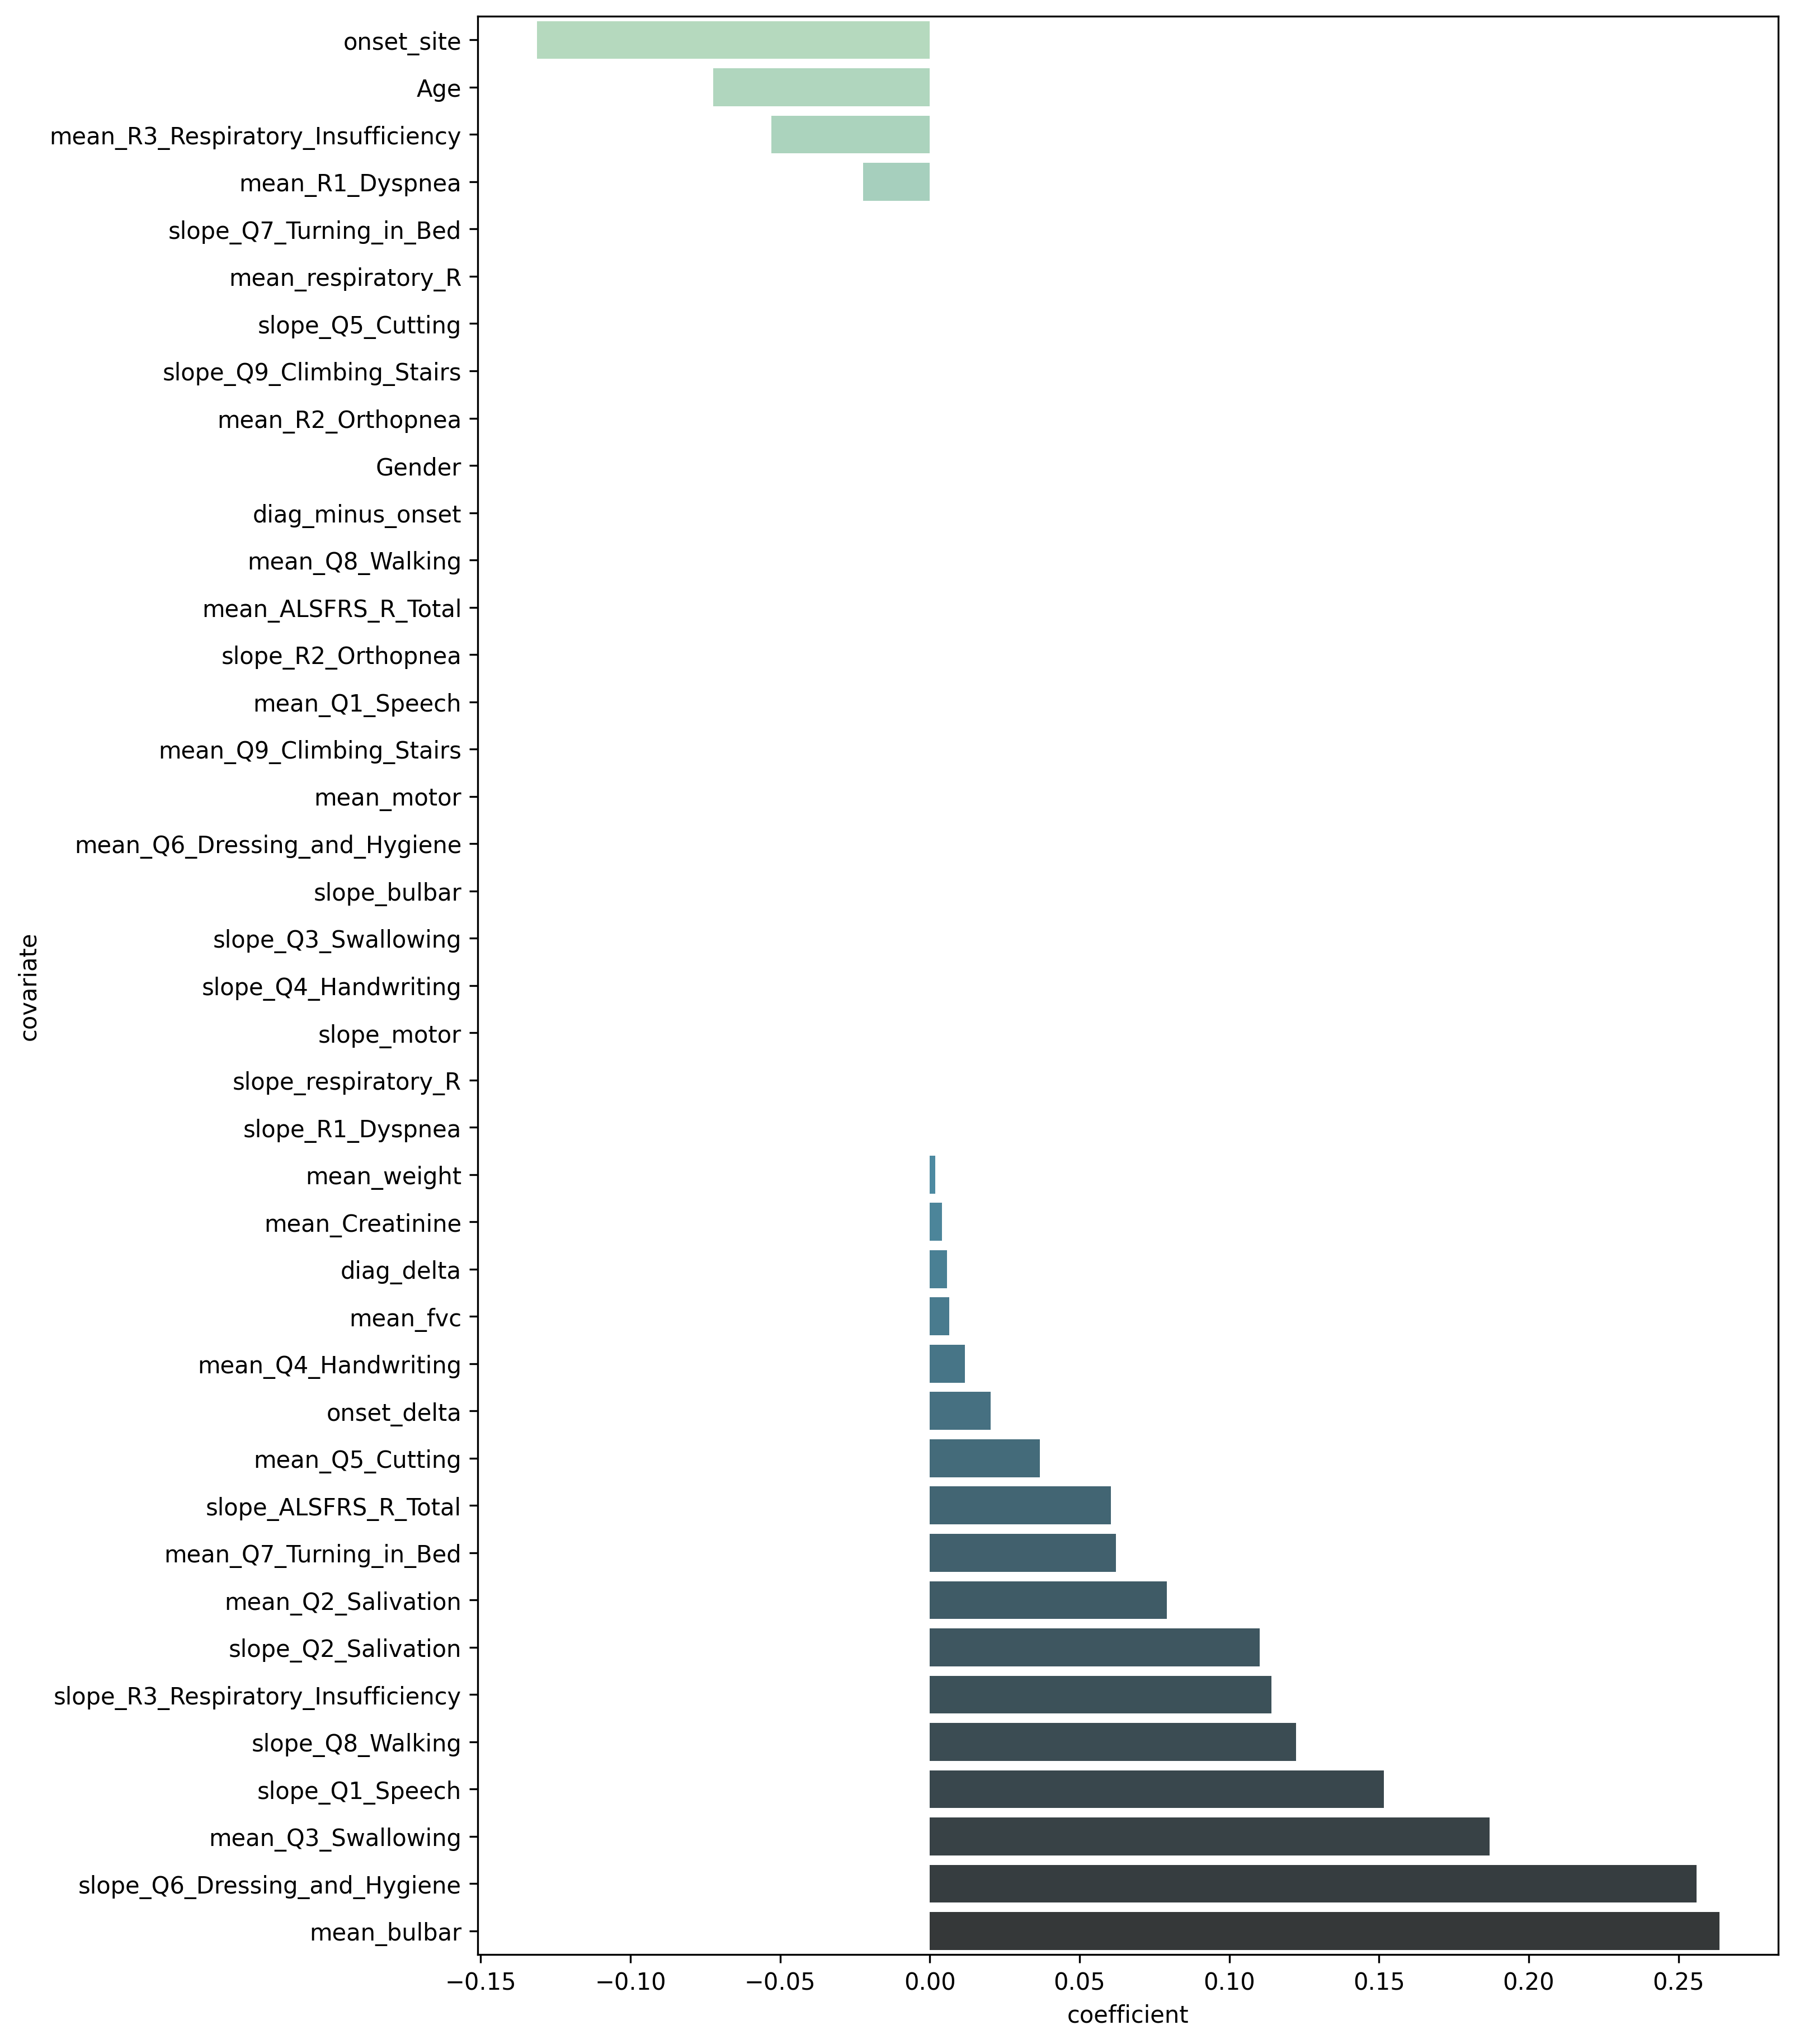

In [ ]:
# Plot coefficients
plt.figure(figsize=(10, 15))
sns.barplot(data=df_aft_coef, x='coefficient', y='covariate', orient='h', palette='GnBu_d')
plt.show()

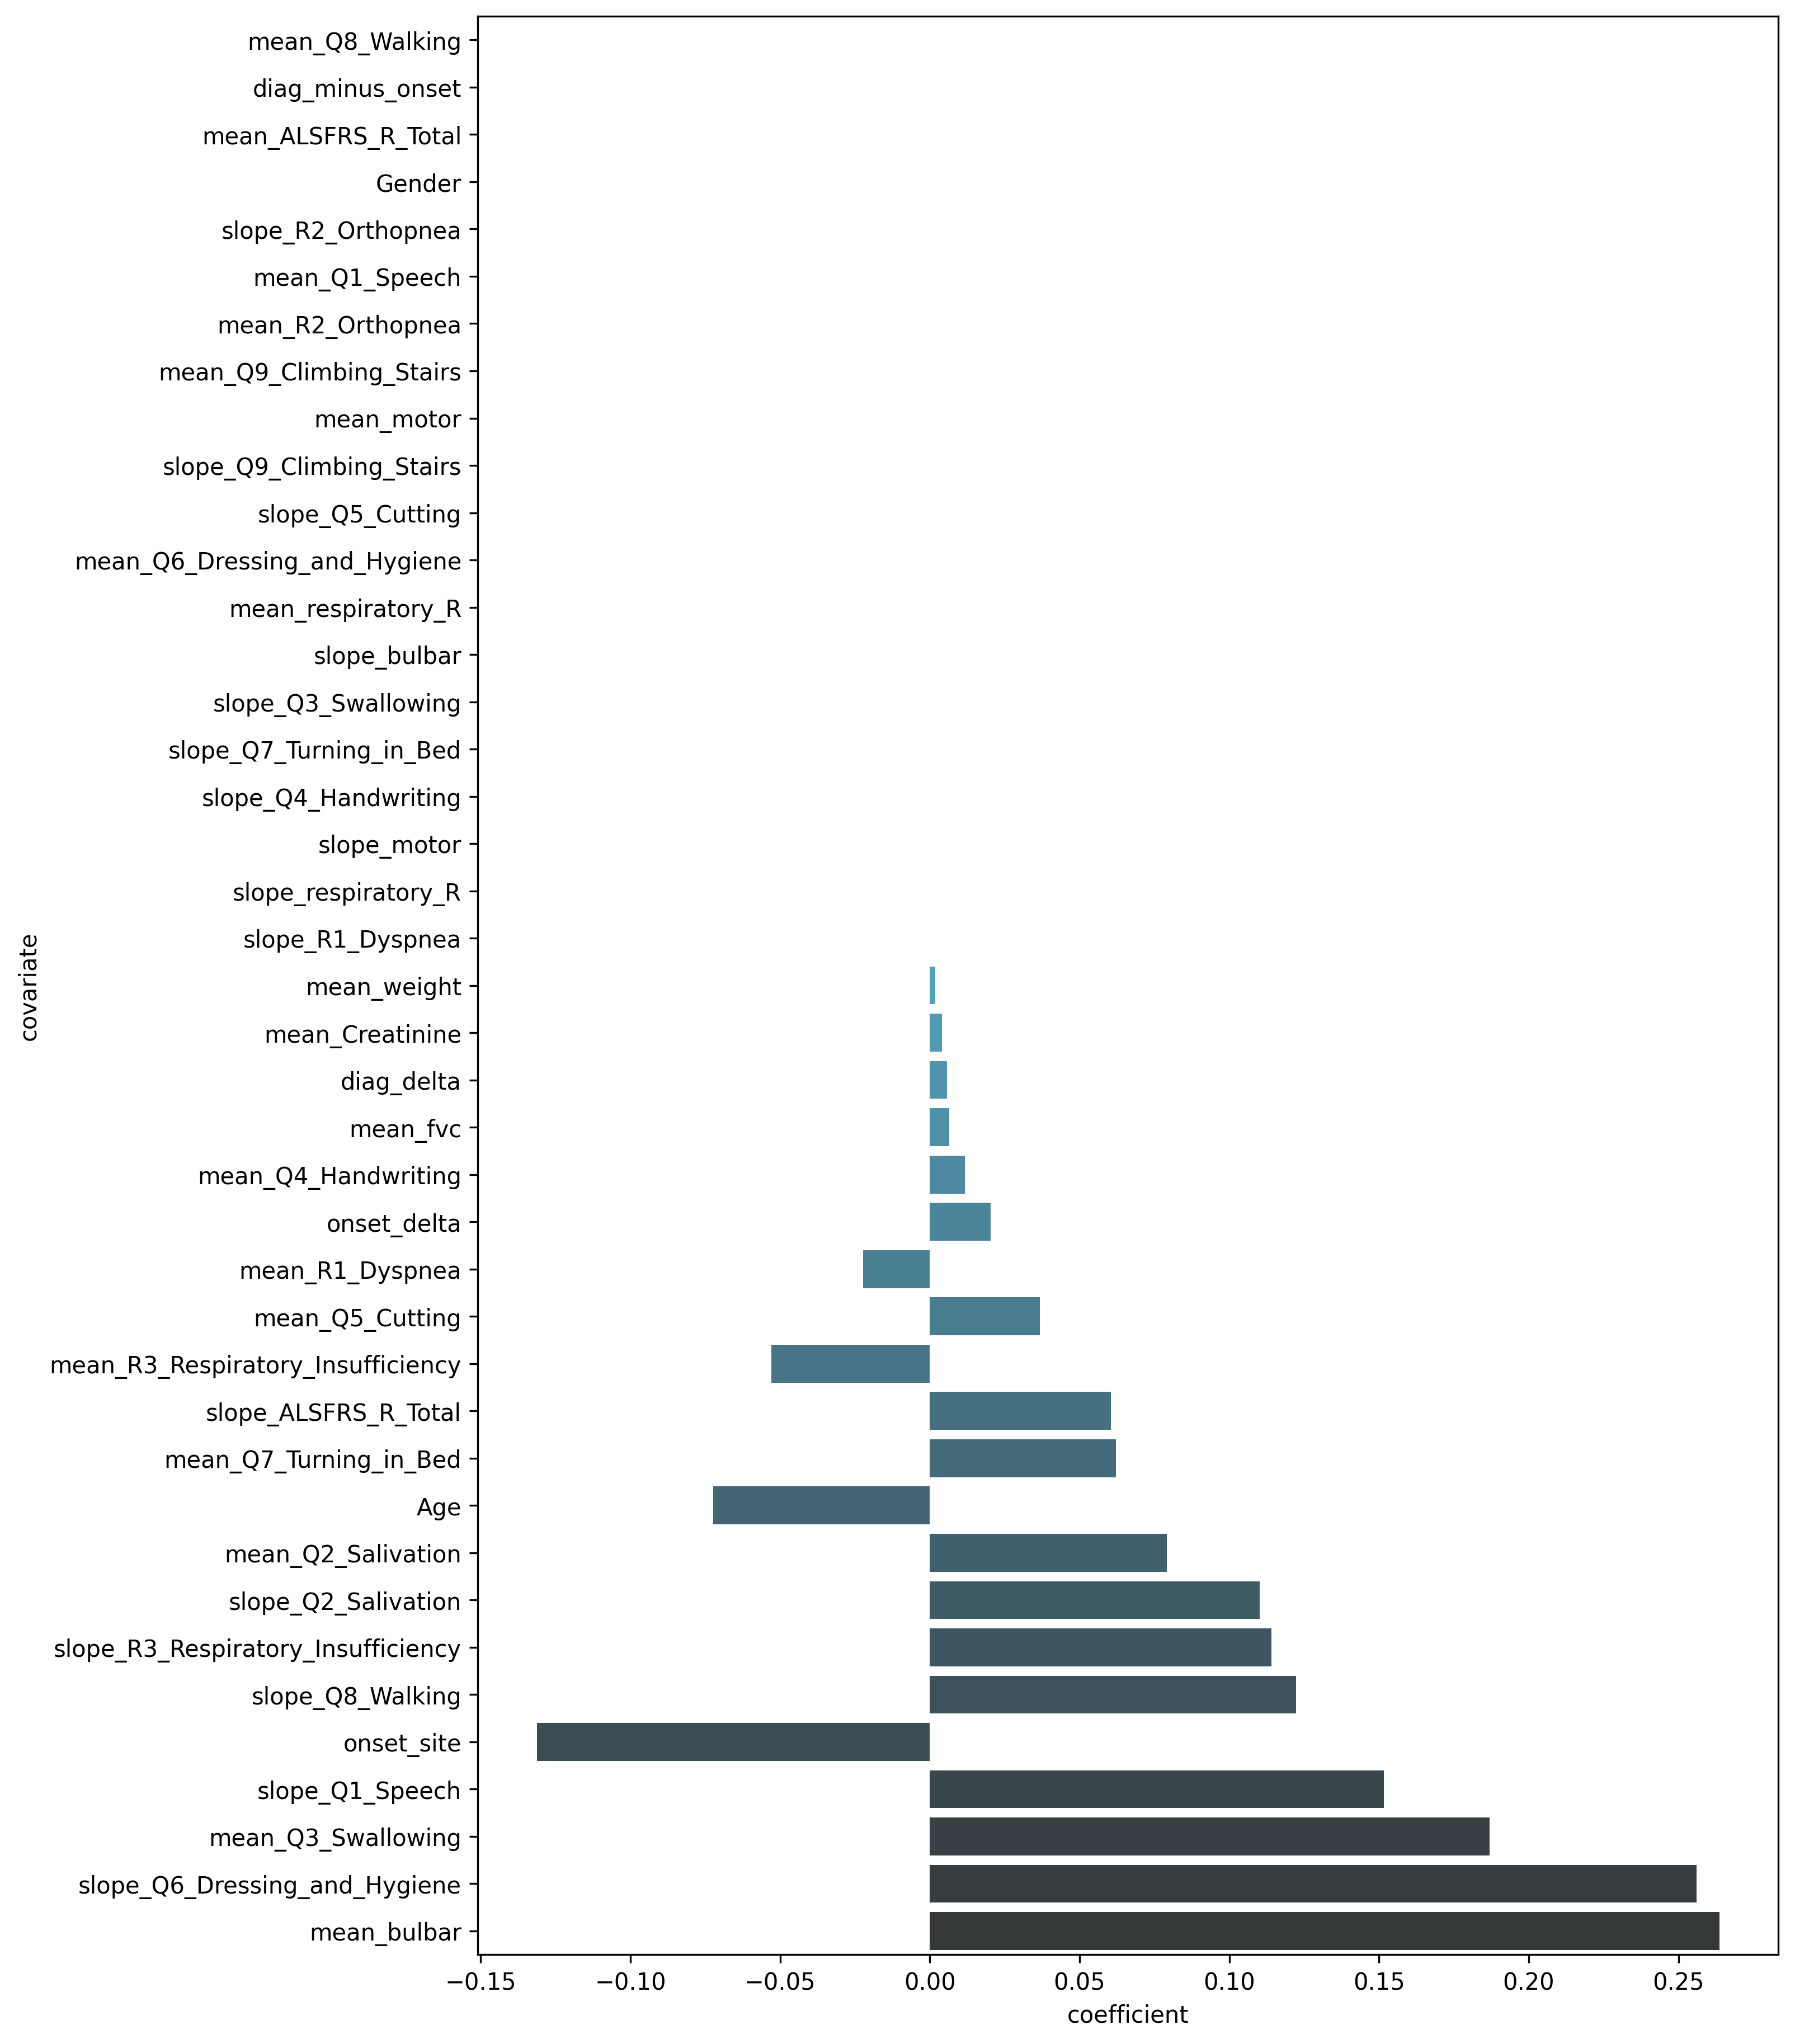

In [ ]:
# Plot coefficients in order of absolute value
df_aft_coef_absolute = df_aft_coef.copy()
sorted_index = np.abs(df_aft_coef_absolute['coefficient']).argsort()
df_aft_coef_absolute = df_aft_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_aft_coef_absolute, x='coefficient', y='covariate', orient='h', palette='GnBu_d')
plt.show()

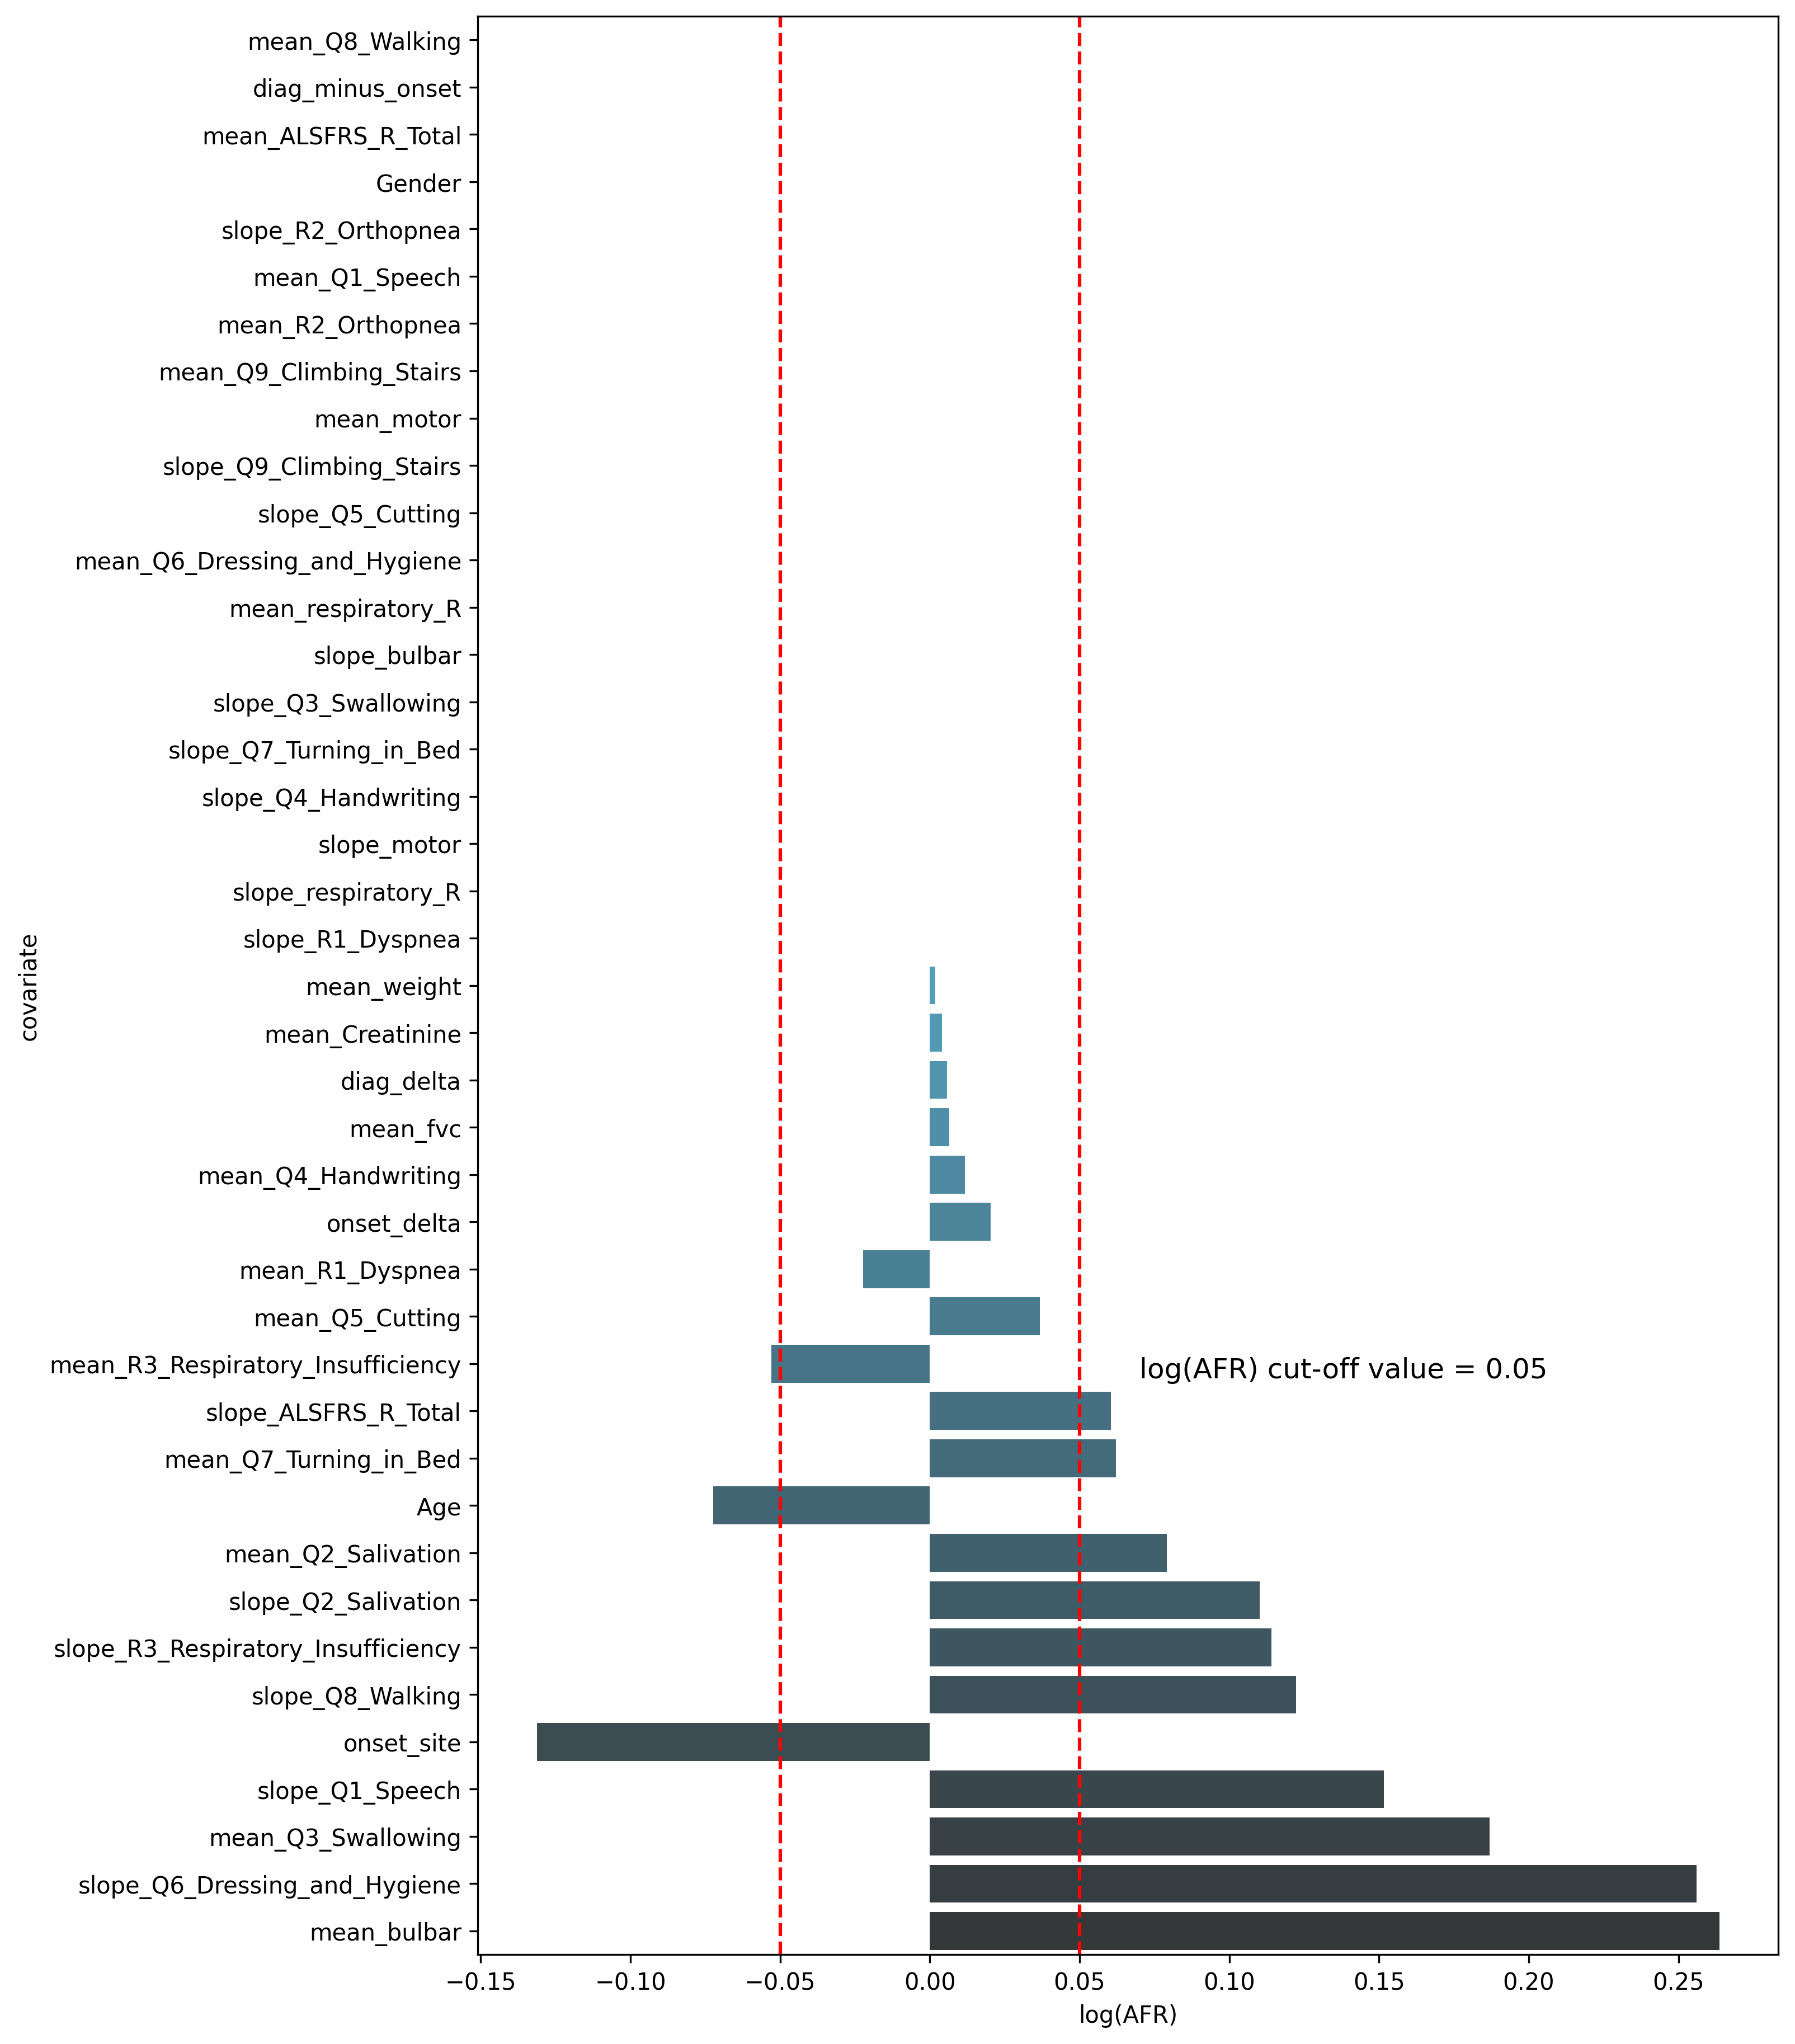

In [ ]:
# Plot coefficients in order of absolute value
df_aft_coef_absolute = df_aft_coef.copy()
sorted_index = np.abs(df_aft_coef_absolute['coefficient']).argsort()
df_aft_coef_absolute = df_aft_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_aft_coef_absolute, x='coefficient', y='covariate', orient='h', palette='GnBu_d')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=-0.05, color='red', linestyle='--')
plt.annotate('log(AFR) cut-off value = 0.05', xy=(0.07, 28.3), color='k', fontsize=12)
plt.xlabel('log(AFR)')
plt.show()

In [ ]:
# Print coefficients with absolute value > 0.05
df_aft_coef_selected =df_aft_coef.query('(coefficient > 0.05) or (coefficient < -0.05)')
df_aft_coef_selected

covariate  coefficient
24                          onset_site    -0.131189
0                                  Age    -0.072356
17   mean_R3_Respiratory_Insufficiency    -0.052833
25                slope_ALSFRS_R_Total     0.060519
12              mean_Q7_Turning_in_Bed     0.062120
7                   mean_Q2_Salivation     0.079180
27                 slope_Q2_Salivation     0.110161
37  slope_R3_Respiratory_Insufficiency     0.114129
33                    slope_Q8_Walking     0.122256
26                     slope_Q1_Speech     0.151611
8                   mean_Q3_Swallowing     0.186981
31       slope_Q6_Dressing_and_Hygiene     0.256076
18                         mean_bulbar     0.263656

In [ ]:
# Features with |coefficient| <= 0.005 are excluded  (feature selection through lasso)
aft_final_feature_list = df_aft_coef_selected['covariate'].tolist()
print("Total " + str(len(aft_final_feature_list)) + " features are selected through lasso in AFT")
print(aft_final_feature_list)

Total 13 features are selected through lasso in AFT
['onset_site', 'Age', 'mean_R3_Respiratory_Insufficiency', 'slope_ALSFRS_R_Total', 'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'slope_Q2_Salivation', 'slope_R3_Respiratory_Insufficiency', 'slope_Q8_Walking', 'slope_Q1_Speech', 'mean_Q3_Swallowing', 'slope_Q6_Dressing_and_Hygiene', 'mean_bulbar']


In [ ]:
# Fit model with selected hyperparameter and features & print summary
aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_for_featsel[aft_final_feature_list+['time_LOA', 'status_LOA']], duration_col='time_LOA', event_col='status_LOA', ancillary=False)

aft.print_summary() # Prints accelerated failure rate & p-value of each feature

<lifelines.WeibullAFTFitter: fitted with 2670 total observations, 2093 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
   number of observations = 2670
number of events observed = 577
           log-likelihood = -2369.50
         time fit was run = 2023-10-19 01:47:18 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                  
lambda_ Age                                 -0.08       0.93       0.01            -0.10            -0.05                 0.90                 0.95
        mean_Q2_Salivation                   0.06       1.07       0.05            -0.03             0.15                 0.98                 1.17
        mean_Q3_Swallowing                   0.19       1.21       0.09             0.03             0.36                 1.03                 1.44
        mean_Q7_Turning_in_Bed               0.10       1.11       0.04             0.03             0.17                 1.03                 1.19
        mean_R3_Respiratory_Insufficiency   -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.13
        mean_bulbar                          0.27       1.31       0.04             0.18             0.36                 1.20                 1.43
        onset_site                          -0.23       0.79       0.09            -0.40            -0.06                 0.67                 0.94
        slope_ALSFRS_R_Total                 0.11       1.11       0.04             0.04             0.18                 1.04                 1.19
        slope_Q1_Speech                      0.26       1.29       0.14            -0.01             0.53                 0.99                 1.69
        slope_Q2_Salivation                  0.11       1.12       0.10            -0.09             0.31                 0.92                 1.37
        slope_Q6_Dressing_and_Hygiene        0.24       1.27       0.13            -0.01             0.49                 0.99                 1.63
        slope_Q8_Walking                     0.15       1.16       0.15            -0.14             0.44                 0.87                 1.55
        slope_R3_Respiratory_Insufficiency   0.03       1.03       0.21            -0.37             0.44                 0.69                 1.55
        Intercept                            1.22       3.38       0.33             0.56             1.87                 1.76                 6.50
rho_    Intercept                            0.37       1.45       0.03             0.31             0.43                 1.36                 1.54

                                             cmp to     z      p   -log2(p)
param   covariate                                                          
lambda_ Age                                    0.00 -5.74 <0.005      26.63
        mean_Q2_Salivation                     0.00  1.41   0.16       2.66
        mean_Q3_Swallowing                     0.00  2.28   0.02       5.46
        mean_Q7_Turning_in_Bed                 0.00  2.77   0.01       7.49
        mean_R3_Respiratory_Insufficiency      0.00 -0.18   0.85       0.23
        mean_bulbar                            0.00  6.15 <0.005      30.28
        onset_site                             0.00 -2.67   0.01       7.05
        slope_ALSFRS_R_Total                   0.00  3.02 <0.005       8.65
        slope_Q1_Speech                        0.00  1.88   0.06       4.06
        slope_Q2_Salivation                    0.00  1.11   0.27       1.90
        slope_Q6_Dressing_and_Hygiene          0.00  1.91   0.06       4.16
        slope_Q8_Walking                       0.00  1.02   0.31       1.69
        slope_R3_Respiratory_Insufficiency     

##1-2. COX

### (1) Hyperparameter tuning with GridSearchCV

In [ ]:
# Hyperparameter tuning for lasso
from sklearn.model_selection import GridSearchCV

cox_params ={ 'penalizer': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.15, 0.2, 0.35,0.5],
              'l1_ratio' : [1]  }

In [ ]:
# 1분 소요
from lifelines import CoxPHFitter
from lifelines.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import KFold

X_cox = df_for_featsel.drop(columns = 'time_LOA')
y_cox = df_for_featsel['time_LOA']

base_class = sklearn_adapter(CoxPHFitter, event_col = 'status_LOA')
cph = base_class()

grid_cv2 = GridSearchCV(cph, param_grid = cox_params, cv = KFold(n_splits = 3), n_jobs = 1)
grid_cv2.fit(X_cox, y_cox)

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SkLearnCoxPHFitter(baseline_estimation_method='breslow',
                                          breakpoints=None, knots=None,
                                          l1_ratio=0.0, n_baseline_knots=None,
                                          penalizer=0.0, strata=None),
             n_jobs=1,
             param_grid={'l1_ratio': [1],
                         'penalizer': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                       0.1, 0.15, 0.2, 0.35, 0.5]})

In [ ]:
# Result
print(grid_cv2.best_score_)  # 0.8432888663593436
print(grid_cv2.best_params_)  # {'l1_ratio': 1, 'penalizer': 0.01} is selected

0.8432888663593436
{'l1_ratio': 1, 'penalizer': 0.01}


In [ ]:
# Result
grid_cv2.cv_results_

{'mean_fit_time': array([1.9397215 , 3.92859038, 2.78512645, 3.00547322, 3.21264537,
        3.66786814, 3.89135949, 3.21158449, 2.84742387, 2.86700813,
        3.0325714 ]),
 'std_fit_time': array([0.02507334, 0.52114538, 0.45442145, 0.63306157, 0.53331254,
        1.22533157, 1.20960553, 0.44285436, 0.11438698, 0.55085333,
        0.80944554]),
 'mean_score_time': array([0.03006887, 0.02825658, 0.04057606, 0.03549727, 0.03365962,
        0.02908397, 0.03899248, 0.03738014, 0.0386165 , 0.02804915,
        0.02831769]),
 'std_score_time': array([0.0038183 , 0.00181521, 0.01834142, 0.01280493, 0.01090122,
        0.00149657, 0.01724397, 0.01388553, 0.01536531, 0.00058377,
        0.0011484 ]),
 'param_l1_ratio': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalizer': masked_array(data=[0.0001, 0.0005, 0

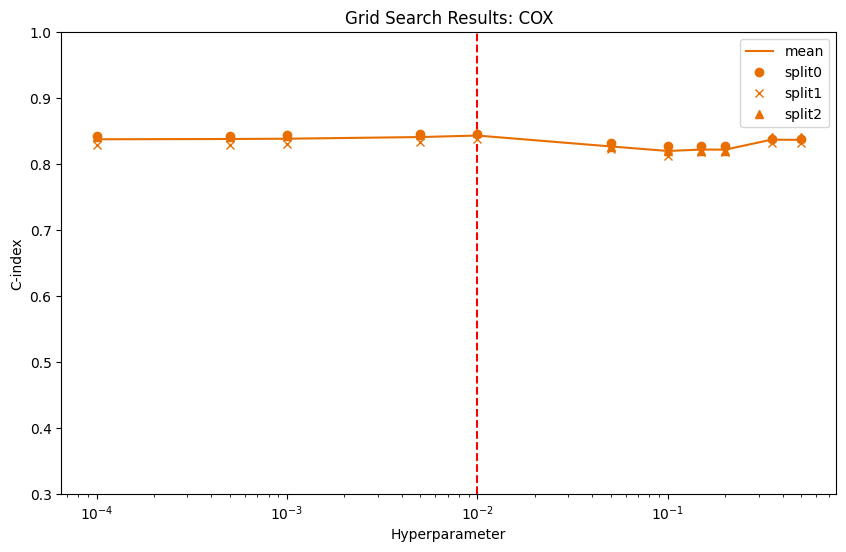

In [ ]:
# Plot the results
cv_results = grid_cv2.cv_results_
cv_results['param_penalizer'] = np.asarray(cv_results['param_penalizer'])

fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(x=0.01, color='red', linestyle='--')  # penalizer = 0.01 showed best score
ax.plot(pd.DataFrame(cv_results)[['param_penalizer']], pd.DataFrame(cv_results)[['mean_test_score']], '-', label='mean', color='#E86E00')
ax.plot(cv_results['param_penalizer'], cv_results['split0_test_score'], 'o', label='split0', color='#E86E00')
ax.plot(cv_results['param_penalizer'], cv_results['split1_test_score'], 'x', label='split1', color='#E86E00')
ax.plot(cv_results['param_penalizer'], cv_results['split2_test_score'], '^', label='split2', color='#E86E00')
ax.set_xscale('log')
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('C-index')
ax.set_title('Grid Search Results: COX')
plt.ylim([0.3, 1.0])
plt.legend()
plt.show()

### (2) Feature selection with Lasso

In [ ]:
# Fit model with selected hyperparameter & print summary
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel, 'time_LOA', event_col='status_LOA')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2670 total observations, 2093 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2670
number of events observed = 577
   partial log-likelihood = -3728.44
         time fit was run = 2023-10-30 10:24:06 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Age                                  0.10       1.11       0.02             0.06             0.14                 1.06                 1.15
Gender                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
diag_delta                          -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
onset_delta                         -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
onset_site                           0.16       1.18       0.13            -0.09             0.42                 0.92                 1.52
diag_minus_onset                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q1_Speech                      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q2_Salivation                  -0.11       0.89       0.07            -0.25             0.02                 0.78                 1.02
mean_Q3_Swallowing                  -0.25       0.78       0.13            -0.50             0.01                 0.61                 1.01
mean_Q4_Handwriting                 -0.00       1.00       0.07            -0.14             0.13                 0.87                 1.14
mean_Q5_Cutting                     -0.04       0.96       0.07            -0.18             0.09                 0.84                 1.09
mean_Q6_Dressing_and_Hygiene        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q7_Turning_in_Bed              -0.08       0.93       0.07            -0.21             0.06                 0.81                 1.06
mean_Q8_Walking                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_Q9_Climbing_Stairs              0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R1_Dyspnea                      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R2_Orthopnea                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_R3_Respiratory_Insufficiency    0.07       1.07       0.10            -0.13             0.26                 0.88                 1.30
mean_ALSFRS_R_Total                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_respiratory_R                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
mean_bulbar                         -0.41       0.67       0.07            -0.54            -0.28                 0.58                 0.76
mean_motor                          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
slope_Q1_Speech                     -0.21       0.81       0.20            -0.60             0.19                 0.55                 1.20
slope_Q2_Salivation                 -0.13       0.87       0.15    

In [ ]:
# Print coefficients in order of size
cph_coef = cph.params_.copy()
df_cph_coef = pd.DataFrame(cph_coef)
df_cph_coef.columns = ['coefficient']
df_cph_coef.reset_index(inplace=True)
df_cph_coef.sort_values(by='coefficient', ascending=True, inplace=True)
df_cph_coef

covariate   coefficient
20                         mean_bulbar -4.068104e-01
27       slope_Q6_Dressing_and_Hygiene -3.075538e-01
8                   mean_Q3_Swallowing -2.472656e-01
22                     slope_Q1_Speech -2.057941e-01
23                 slope_Q2_Salivation -1.338365e-01
29                    slope_Q8_Walking -1.241264e-01
7                   mean_Q2_Salivation -1.138830e-01
34                slope_ALSFRS_R_Total -1.089706e-01
12              mean_Q7_Turning_in_Bed -7.730603e-02
33  slope_R3_Respiratory_Insufficiency -4.888110e-02
10                     mean_Q5_Cutting -4.462008e-02
3                          onset_delta -2.956669e-02
38                            mean_fvc -9.202495e-03
39                     mean_Creatinine -5.126179e-03
2                           diag_delta -4.053167e-03
9                  mean_Q4_Handwriting -4.037631e-03
40                         mean_weight -2.569655e-03
36                        slope_bulbar -1.609754e-07
26                    slope_Q5_Cutting -8.805035e-08
1                               Gender -8.725724e-08
31                    slope_R1_Dyspnea -8.111070e-08
6                       mean_Q1_Speech -7.545340e-08
13                     mean_Q8_Walking -6.356019e-08
25                slope_Q4_Handwriting -6.310175e-08
37                         slope_motor -5.652147e-08
35                 slope_respiratory_R -3.952620e-08
11        mean_Q6_Dressing_and_Hygiene -3.566473e-08
16                   mean_R2_Orthopnea -2.690139e-08
18                 mean_ALSFRS_R_Total -1.982794e-08
21                          mean_motor -1.296015e-08
5                     diag_minus_onset  2.601389e-09
14             mean_Q9_Climbing_Stairs  5.855854e-09
24                 slope_Q3_Swallowing  8.000625e-09
30            slope_Q9_Climbing_Stairs  1.234345e-08
28             slope_Q7_Turning_in_Bed  2.475433e-08
19                  mean_respiratory_R  3.790641e-08
15                     mean_R1_Dyspnea  8.629870e-08
32                  slope_R2_Orthopnea  1.671285e-07
17   mean_R3_Respiratory_Insufficiency  6.512629e-02
0                                  Age  1.006876e-01
4                           onset_site  1.647563e-01

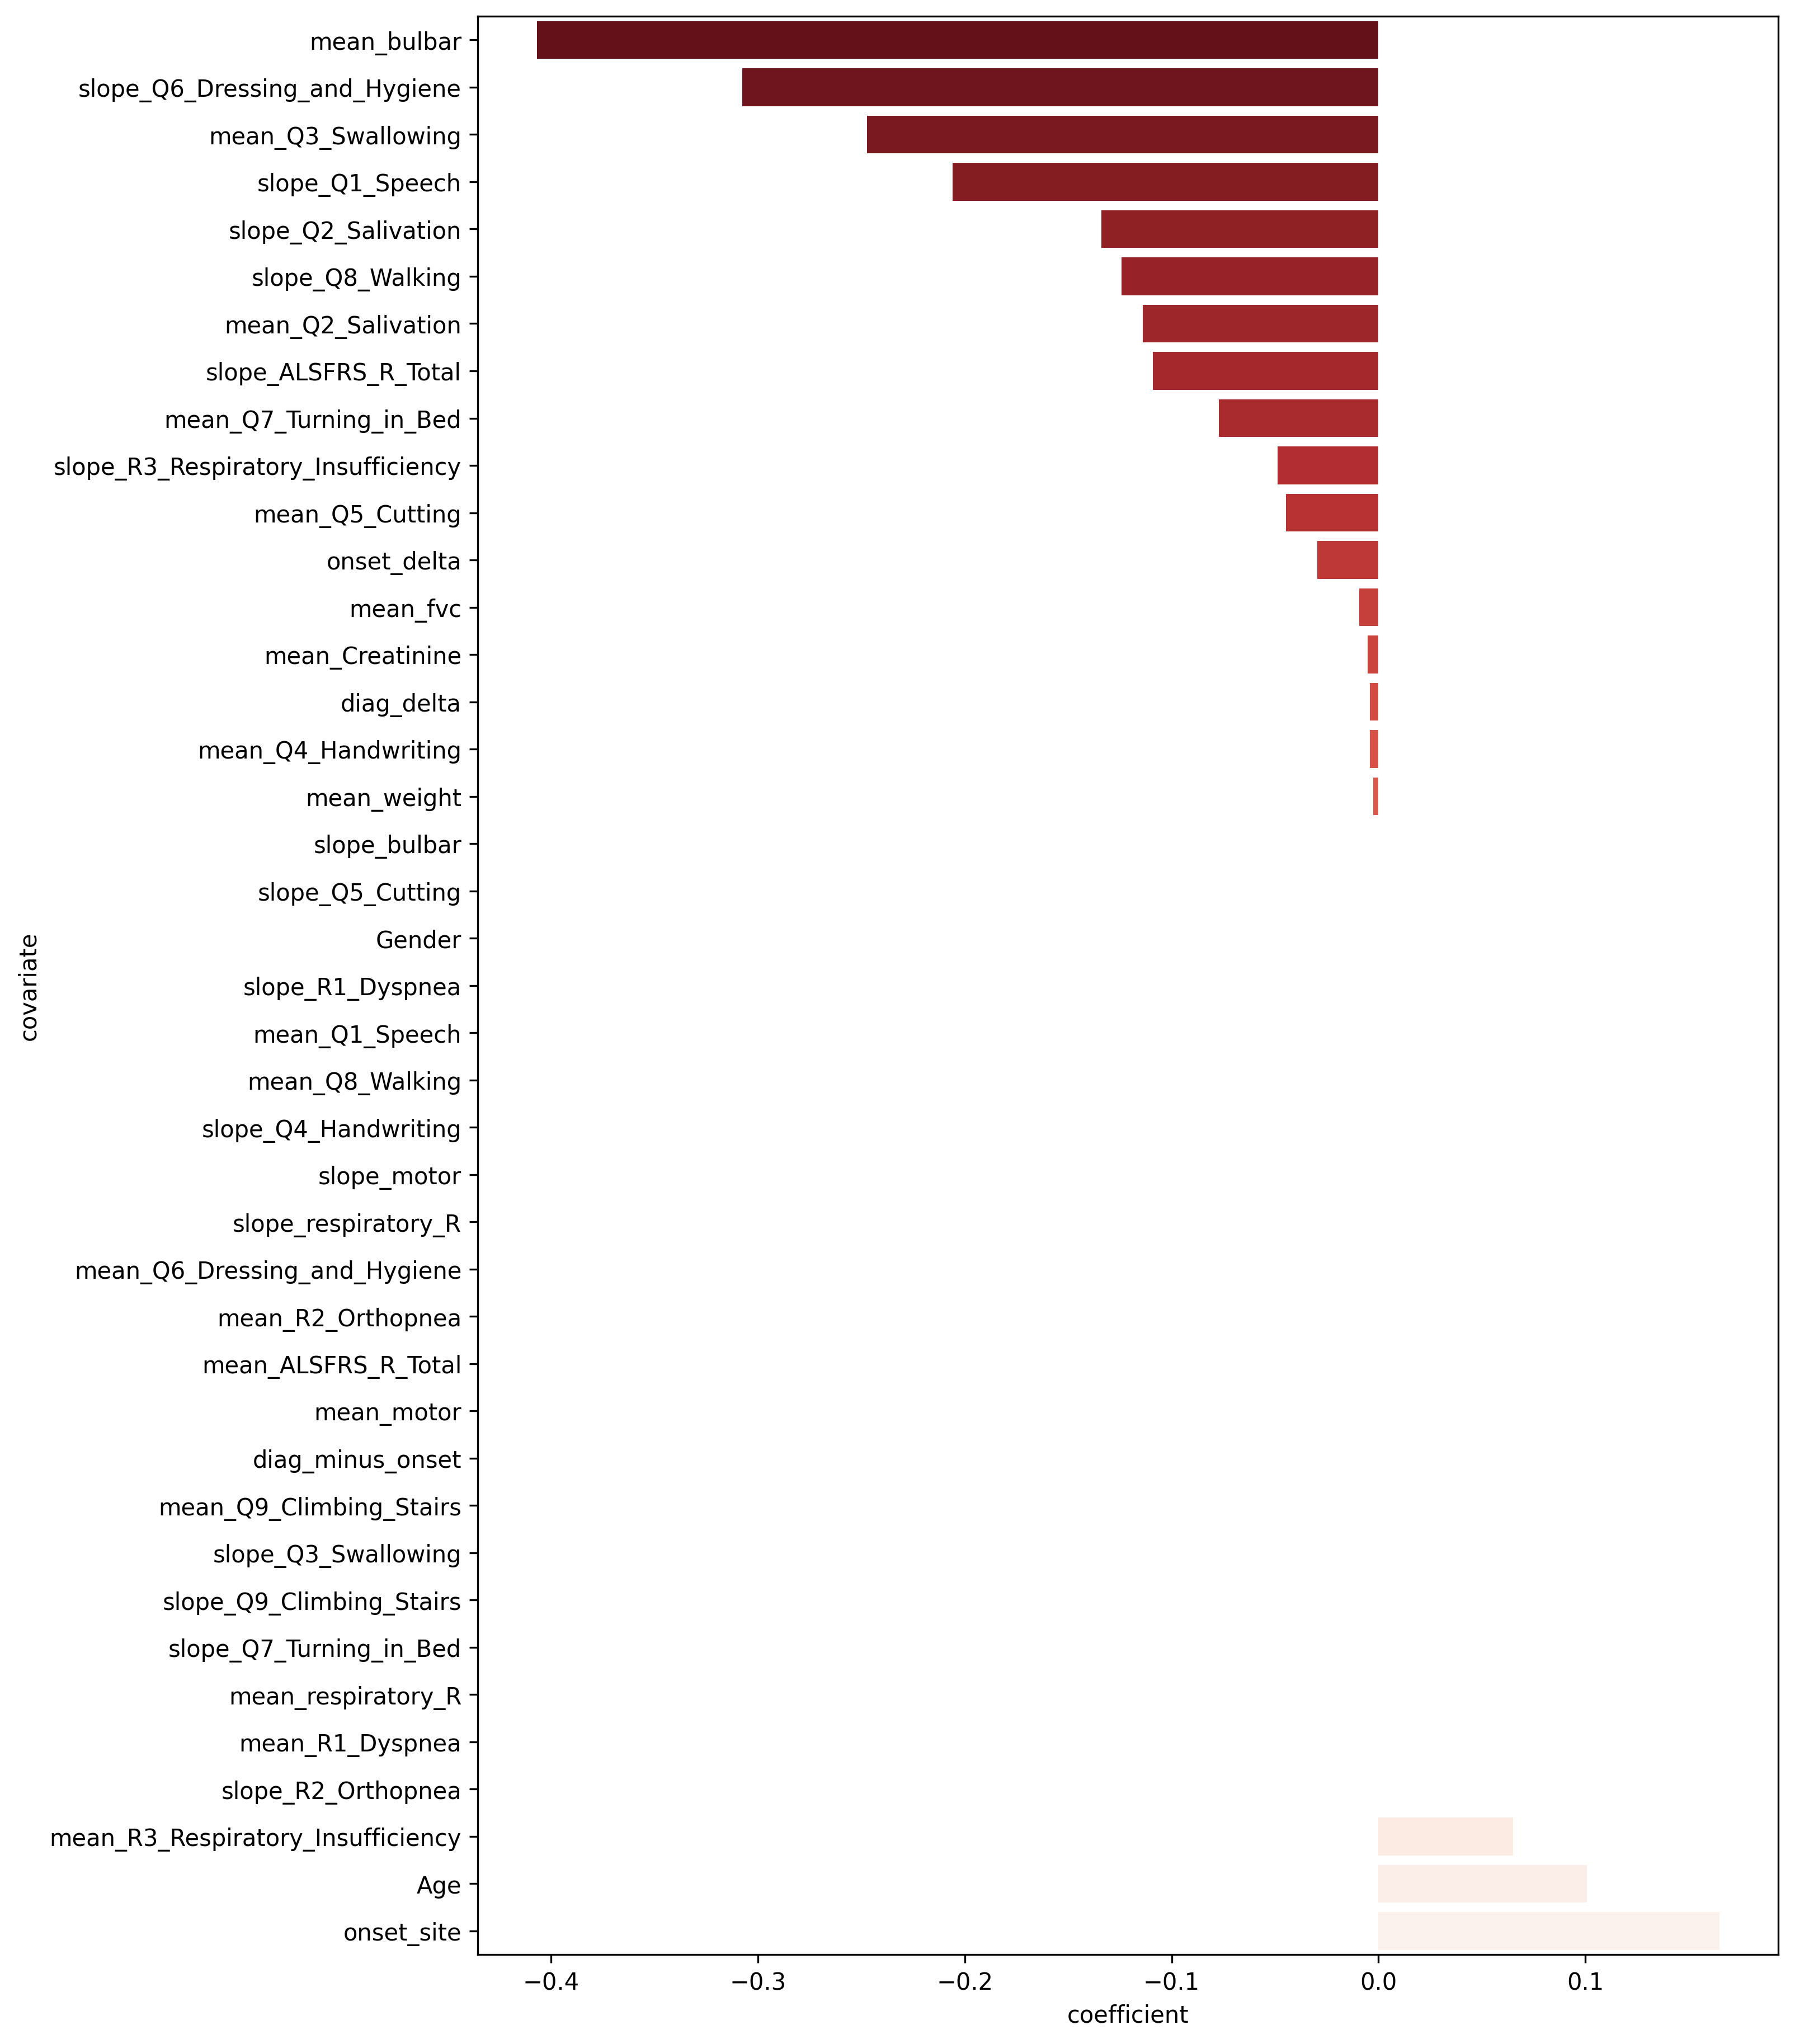

In [ ]:
# Plot coefficients
plt.figure(figsize=(10, 15))
sns.barplot(data=df_cph_coef, x='coefficient', y='covariate', orient='h', palette="Reds_r")
plt.show()

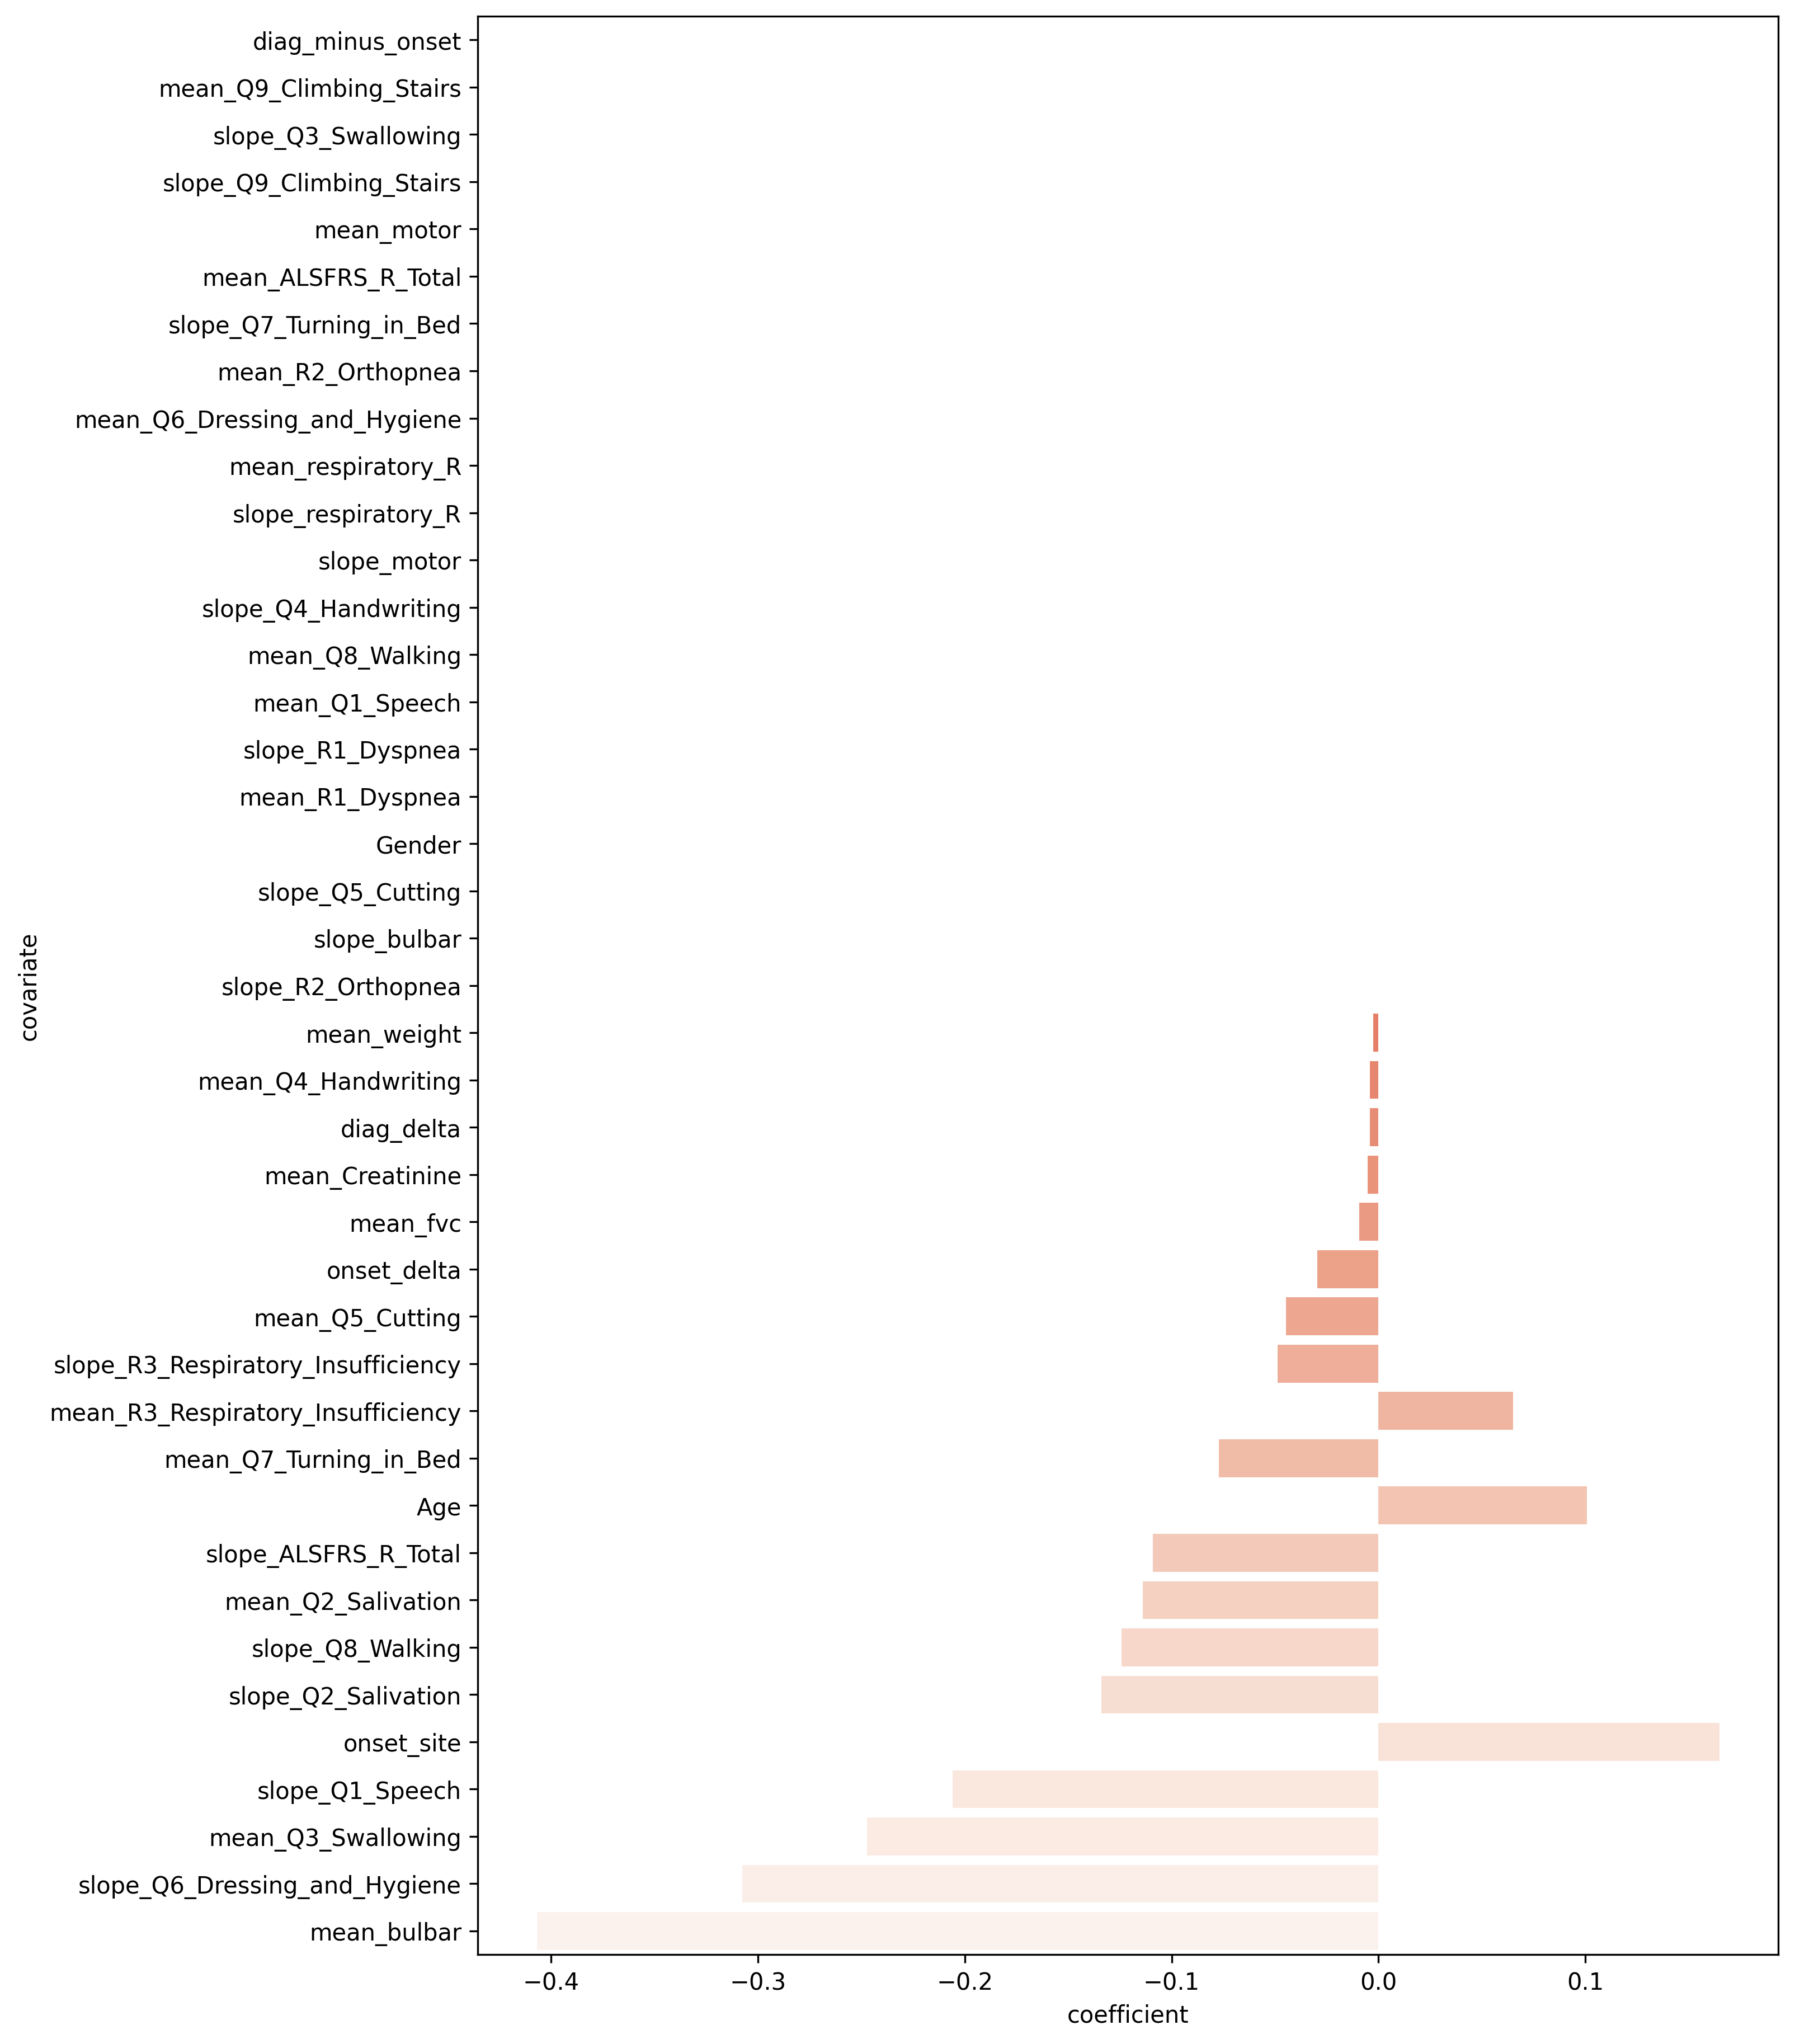

In [ ]:
# Plot coefficients in order of absolute value
df_cph_coef_absolute = df_cph_coef.copy()
sorted_index = np.abs(df_cph_coef_absolute['coefficient']).argsort()
df_cph_coef_absolute = df_cph_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_cph_coef_absolute, x='coefficient', y='covariate', orient='h', palette="Reds_r")
plt.show()

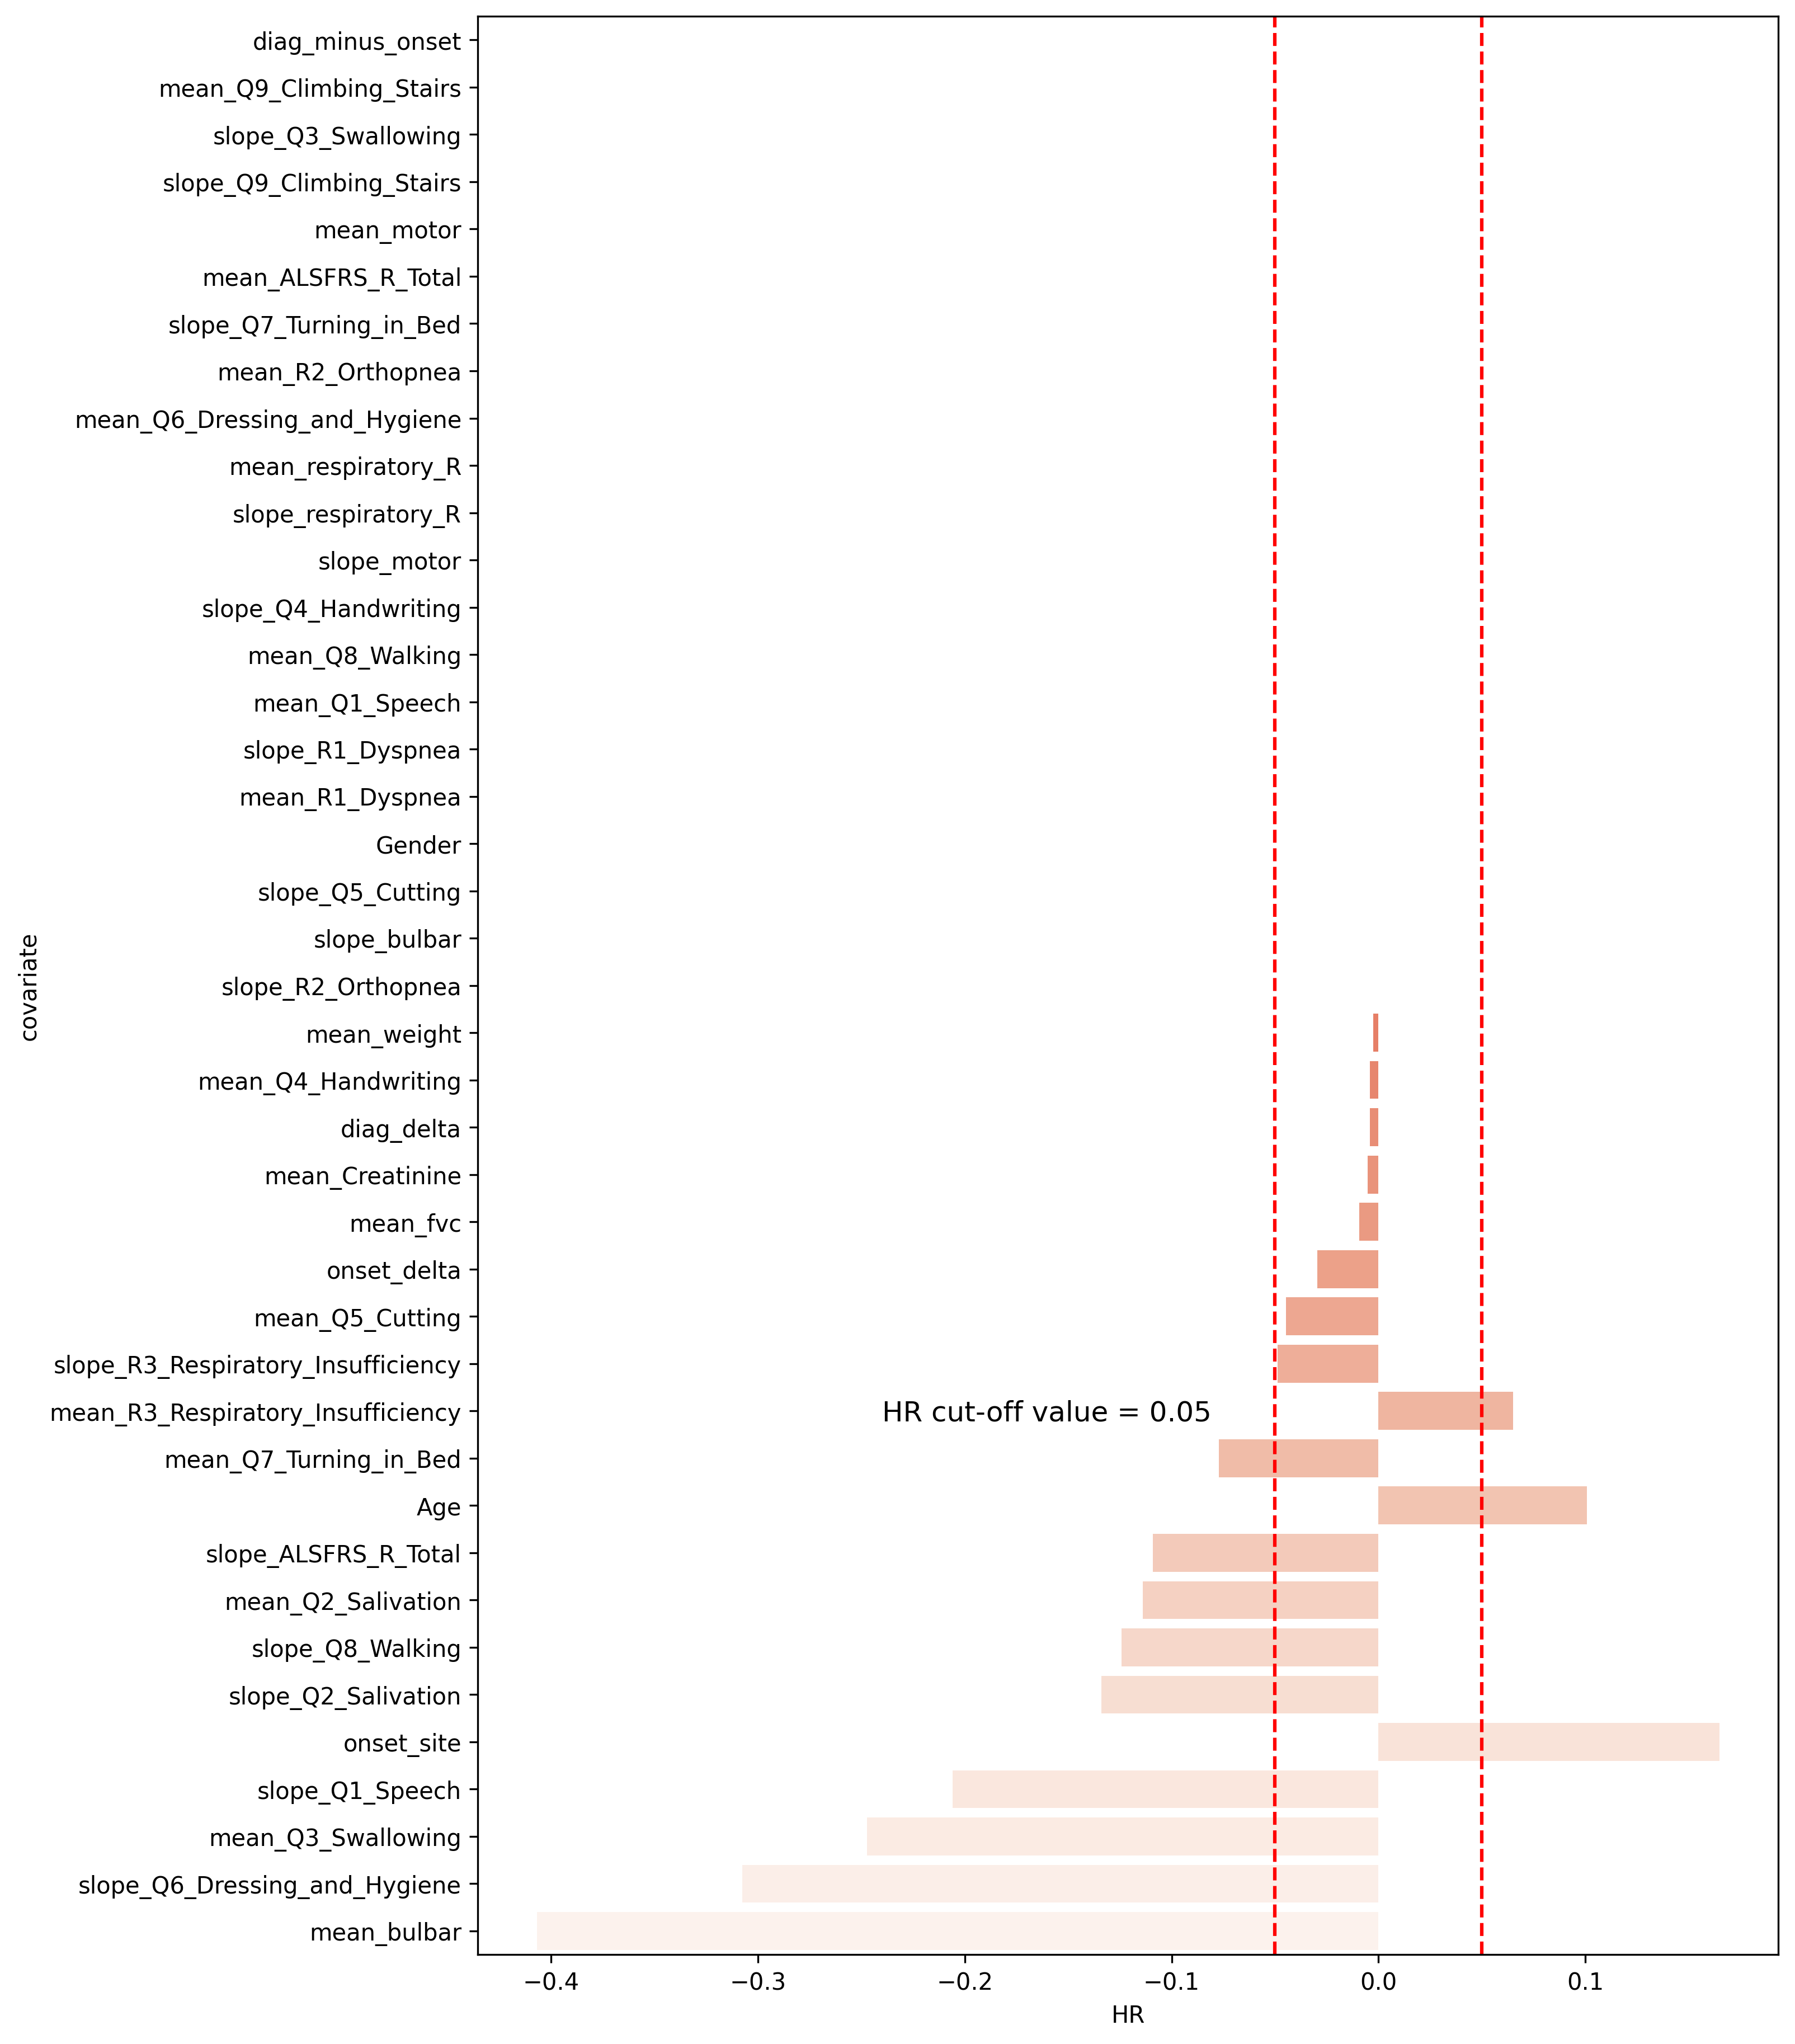

In [ ]:
# Plot coefficients in order of absolute value
df_cph_coef_absolute = df_cph_coef.copy()
sorted_index = np.abs(df_cph_coef_absolute['coefficient']).argsort()
df_cph_coef_absolute = df_cph_coef_absolute.iloc[sorted_index].reset_index(drop=True)

plt.figure(figsize=(10, 15))
sns.barplot(data=df_cph_coef_absolute, x='coefficient', y='covariate', orient='h', palette="Reds_r")
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=-0.05, color='red', linestyle='--')
plt.annotate('HR cut-off value = 0.05', xy=(-0.24, 29.2), color='k', fontsize=12)
plt.xlabel('HR')
plt.show()

In [ ]:
# Print coefficients with absolute value > 0.05
df_cph_coef_selected =df_cph_coef.query('(coefficient > 0.05) or (coefficient < -0.05)')
df_cph_coef_selected

covariate  coefficient
20                        mean_bulbar    -0.406810
27      slope_Q6_Dressing_and_Hygiene    -0.307554
8                  mean_Q3_Swallowing    -0.247266
22                    slope_Q1_Speech    -0.205794
23                slope_Q2_Salivation    -0.133837
29                   slope_Q8_Walking    -0.124126
7                  mean_Q2_Salivation    -0.113883
34               slope_ALSFRS_R_Total    -0.108971
12             mean_Q7_Turning_in_Bed    -0.077306
17  mean_R3_Respiratory_Insufficiency     0.065126
0                                 Age     0.100688
4                          onset_site     0.164756

In [ ]:
# Features with |coefficient| <= 0.01 are excluded  (feature selection through lasso)
cph_final_feature_list = df_cph_coef_selected['covariate'].tolist()
print("Total " + str(len(cph_final_feature_list)) + " features are selected through lasso in COX")
print(cph_final_feature_list)

Total 12 features are selected through lasso in COX
['mean_bulbar', 'slope_Q6_Dressing_and_Hygiene', 'mean_Q3_Swallowing', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q8_Walking', 'mean_Q2_Salivation', 'slope_ALSFRS_R_Total', 'mean_Q7_Turning_in_Bed', 'mean_R3_Respiratory_Insufficiency', 'Age', 'onset_site']


In [ ]:
# Fit model with selected hyperparameter and features & print summary
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_for_featsel[cph_final_feature_list+['time_LOA', 'status_LOA']], 'time_LOA', event_col='status_LOA')
cph.print_summary() # Prints hazard ratio & p-value of each feature

<lifelines.CoxPHFitter: fitted with 2670 total observations, 2093 right-censored observations>
             duration col = 'time_LOA'
                event col = 'status_LOA'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 2670
number of events observed = 577
   partial log-likelihood = -3755.14
         time fit was run = 2023-10-19 01:49:20 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
mean_bulbar                        -0.40       0.67       0.06            -0.53            -0.28                 0.59                 0.75
slope_Q6_Dressing_and_Hygiene      -0.28       0.75       0.18            -0.64             0.08                 0.53                 1.08
mean_Q3_Swallowing                 -0.26       0.77       0.12            -0.50            -0.02                 0.60                 0.98
slope_Q1_Speech                    -0.35       0.70       0.20            -0.74             0.03                 0.48                 1.03
slope_Q2_Salivation                -0.13       0.88       0.15            -0.42             0.16                 0.66                 1.17
slope_Q8_Walking                   -0.16       0.85       0.22            -0.59             0.26                 0.56                 1.30
mean_Q2_Salivation                 -0.09       0.91       0.07            -0.22             0.04                 0.80                 1.04
slope_ALSFRS_R_Total               -0.17       0.85       0.05            -0.26            -0.07                 0.77                 0.93
mean_Q7_Turning_in_Bed             -0.13       0.88       0.05            -0.23            -0.02                 0.79                 0.98
mean_R3_Respiratory_Insufficiency   0.01       1.01       0.09            -0.17             0.19                 0.84                 1.21
Age                                 0.10       1.11       0.02             0.06             0.14                 1.07                 1.15
onset_site                          0.30       1.35       0.13             0.05             0.55                 1.05                 1.73

                                    cmp to     z      p   -log2(p)
covariate                                                         
mean_bulbar                           0.00 -6.45 <0.005      33.07
slope_Q6_Dressing_and_Hygiene         0.00 -1.55   0.12       3.04
mean_Q3_Swallowing                    0.00 -2.11   0.03       4.84
slope_Q1_Speech                       0.00 -1.80   0.07       3.78
slope_Q2_Salivation                   0.00 -0.89   0.37       1.43
slope_Q8_Walking                      0.00 -0.74   0.46       1.13
mean_Q2_Salivation                    0.00 -1.40   0.16       2.64
slope_ALSFRS_R_Total                  0.00 -3.39 <0.005      10.46
mean_Q7_Turning_in_Bed                0.00 -2.35   0.02       5.73
mean_R3_Respiratory_Insufficiency     0.00  0.10   0.92       0.12
Age                                   0.00  5.25 <0.005      22.67
onset_site                            0.00  2.38   0.02       5.85
---
Concordance = 0.83
Partial AIC = 7534.29
log-likelihood ratio test = 622.31 on 12 df
-log2(p) of ll-ratio test = 414.38

##1-3. RSF

### (1) Hyperparmeter tuning with GridSearchCV

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_for_featsel.iloc[:, -2:][['status_LOA', 'time_LOA']]
df_train_rsf = df_train_rsf.replace({'status_LOA':dic})

In [ ]:
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 10.18), ( True,  6.44), (False,  2.06), ...,
       (False,  9.82), (False,  3.05), (False,  1.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
#set hyperparameters values
params ={ 'n_estimators':[100],
          'max_features':['auto', 'sqrt','log2', None],
          'min_samples_leaf':[10,14,18],
          'min_samples_split':[8,12,16] }

In [ ]:
#CAUTION! Runtime takes about 1 hour
from sklearn.model_selection import KFold
rf = RandomSurvivalForest(random_state=20, n_jobs=-1)
grid_cv3 = GridSearchCV(rf, param_grid=params, cv=KFold(n_splits = 2), n_jobs=-1)
GG = grid_cv3.fit(df_for_featsel.iloc[:,:-2], y_train_rsf)

In [ ]:
grid_cv3.cv_results_

{'mean_fit_time': array([ 24.88716996,  23.80926907,  24.04294217,  23.58280361,
         23.63395858,  21.93900645,  21.30454659,  20.0274204 ,
         21.23560286,  24.62806189,  23.55569804,  24.76457357,
         23.28971219,  21.59847784,  23.23240542,  20.61916924,
         20.25959027,  20.27757025,  20.79051507,  20.69204319,
         20.61935961,  17.73691702,  19.35326195,  17.72102761,
         17.17986727,  18.13952124,  17.78146386, 169.65159404,
        169.4760778 , 170.75486028, 150.54516244, 155.91668952,
        151.45451951, 136.38017607, 138.67243445, 133.3196342 ]),
 'std_fit_time': array([ 0.57774937,  0.35729802,  0.46546137,  0.87170565,  0.72467947,
         0.74949658,  0.39180851,  0.42464793,  0.31734729,  0.82941163,
         0.79291546,  0.59054351,  0.73859763,  0.46845889,  0.73421454,
         0.39199018,  0.29054129,  0.43157911,  0.31383431,  0.15859401,
         0.12915552,  0.31429386,  0.31780243,  0.4399066 ,  0.35072756,
         0.18411171,  0.

In [ ]:
# Result
print(grid_cv3.best_score_) # 0.8427167632389192
print(grid_cv3.best_params_) # {'max_features': 'auto', 'min_samples_leaf': 10 'min_samples_split': 8, 'n_estimators': 100} is selected

0.8427167632389192
{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 100}


### (2) Feature selection with Permutation importance

In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=65d70c10a27f8b2f2ae941f6af0da66eb355a68792b97770bda25d2d76d483bf
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
from sklearn.utils.metaestimators import available_if as if_delegate_has_method

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
rsf_feature_list = df_for_featsel.columns.tolist()
remove_set = {'time_LOA', 'status_LOA'}

rsf_feature_list = [i for i in rsf_feature_list if i not in remove_set]

In [ ]:
#52초 소요
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=8,
                           min_samples_leaf=10,
                           max_features="auto",
                           n_jobs=-1,
                           random_state=20)
rsf.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(max_features='auto', min_samples_leaf=10,
                     min_samples_split=8, n_jobs=-1, random_state=20)

In [ ]:
#26분 소요
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=100, random_state=20)
perm.fit(df_for_featsel[rsf_feature_list], y_train_rsf)

PermutationImportance(estimator=RandomSurvivalForest(max_features='auto',
                                                     min_samples_leaf=10,
                                                     min_samples_split=8,
                                                     n_jobs=-1,
                                                     random_state=20),
                      n_iter=100, random_state=20)

<ipython-input-23-e90cd61a8cea>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )


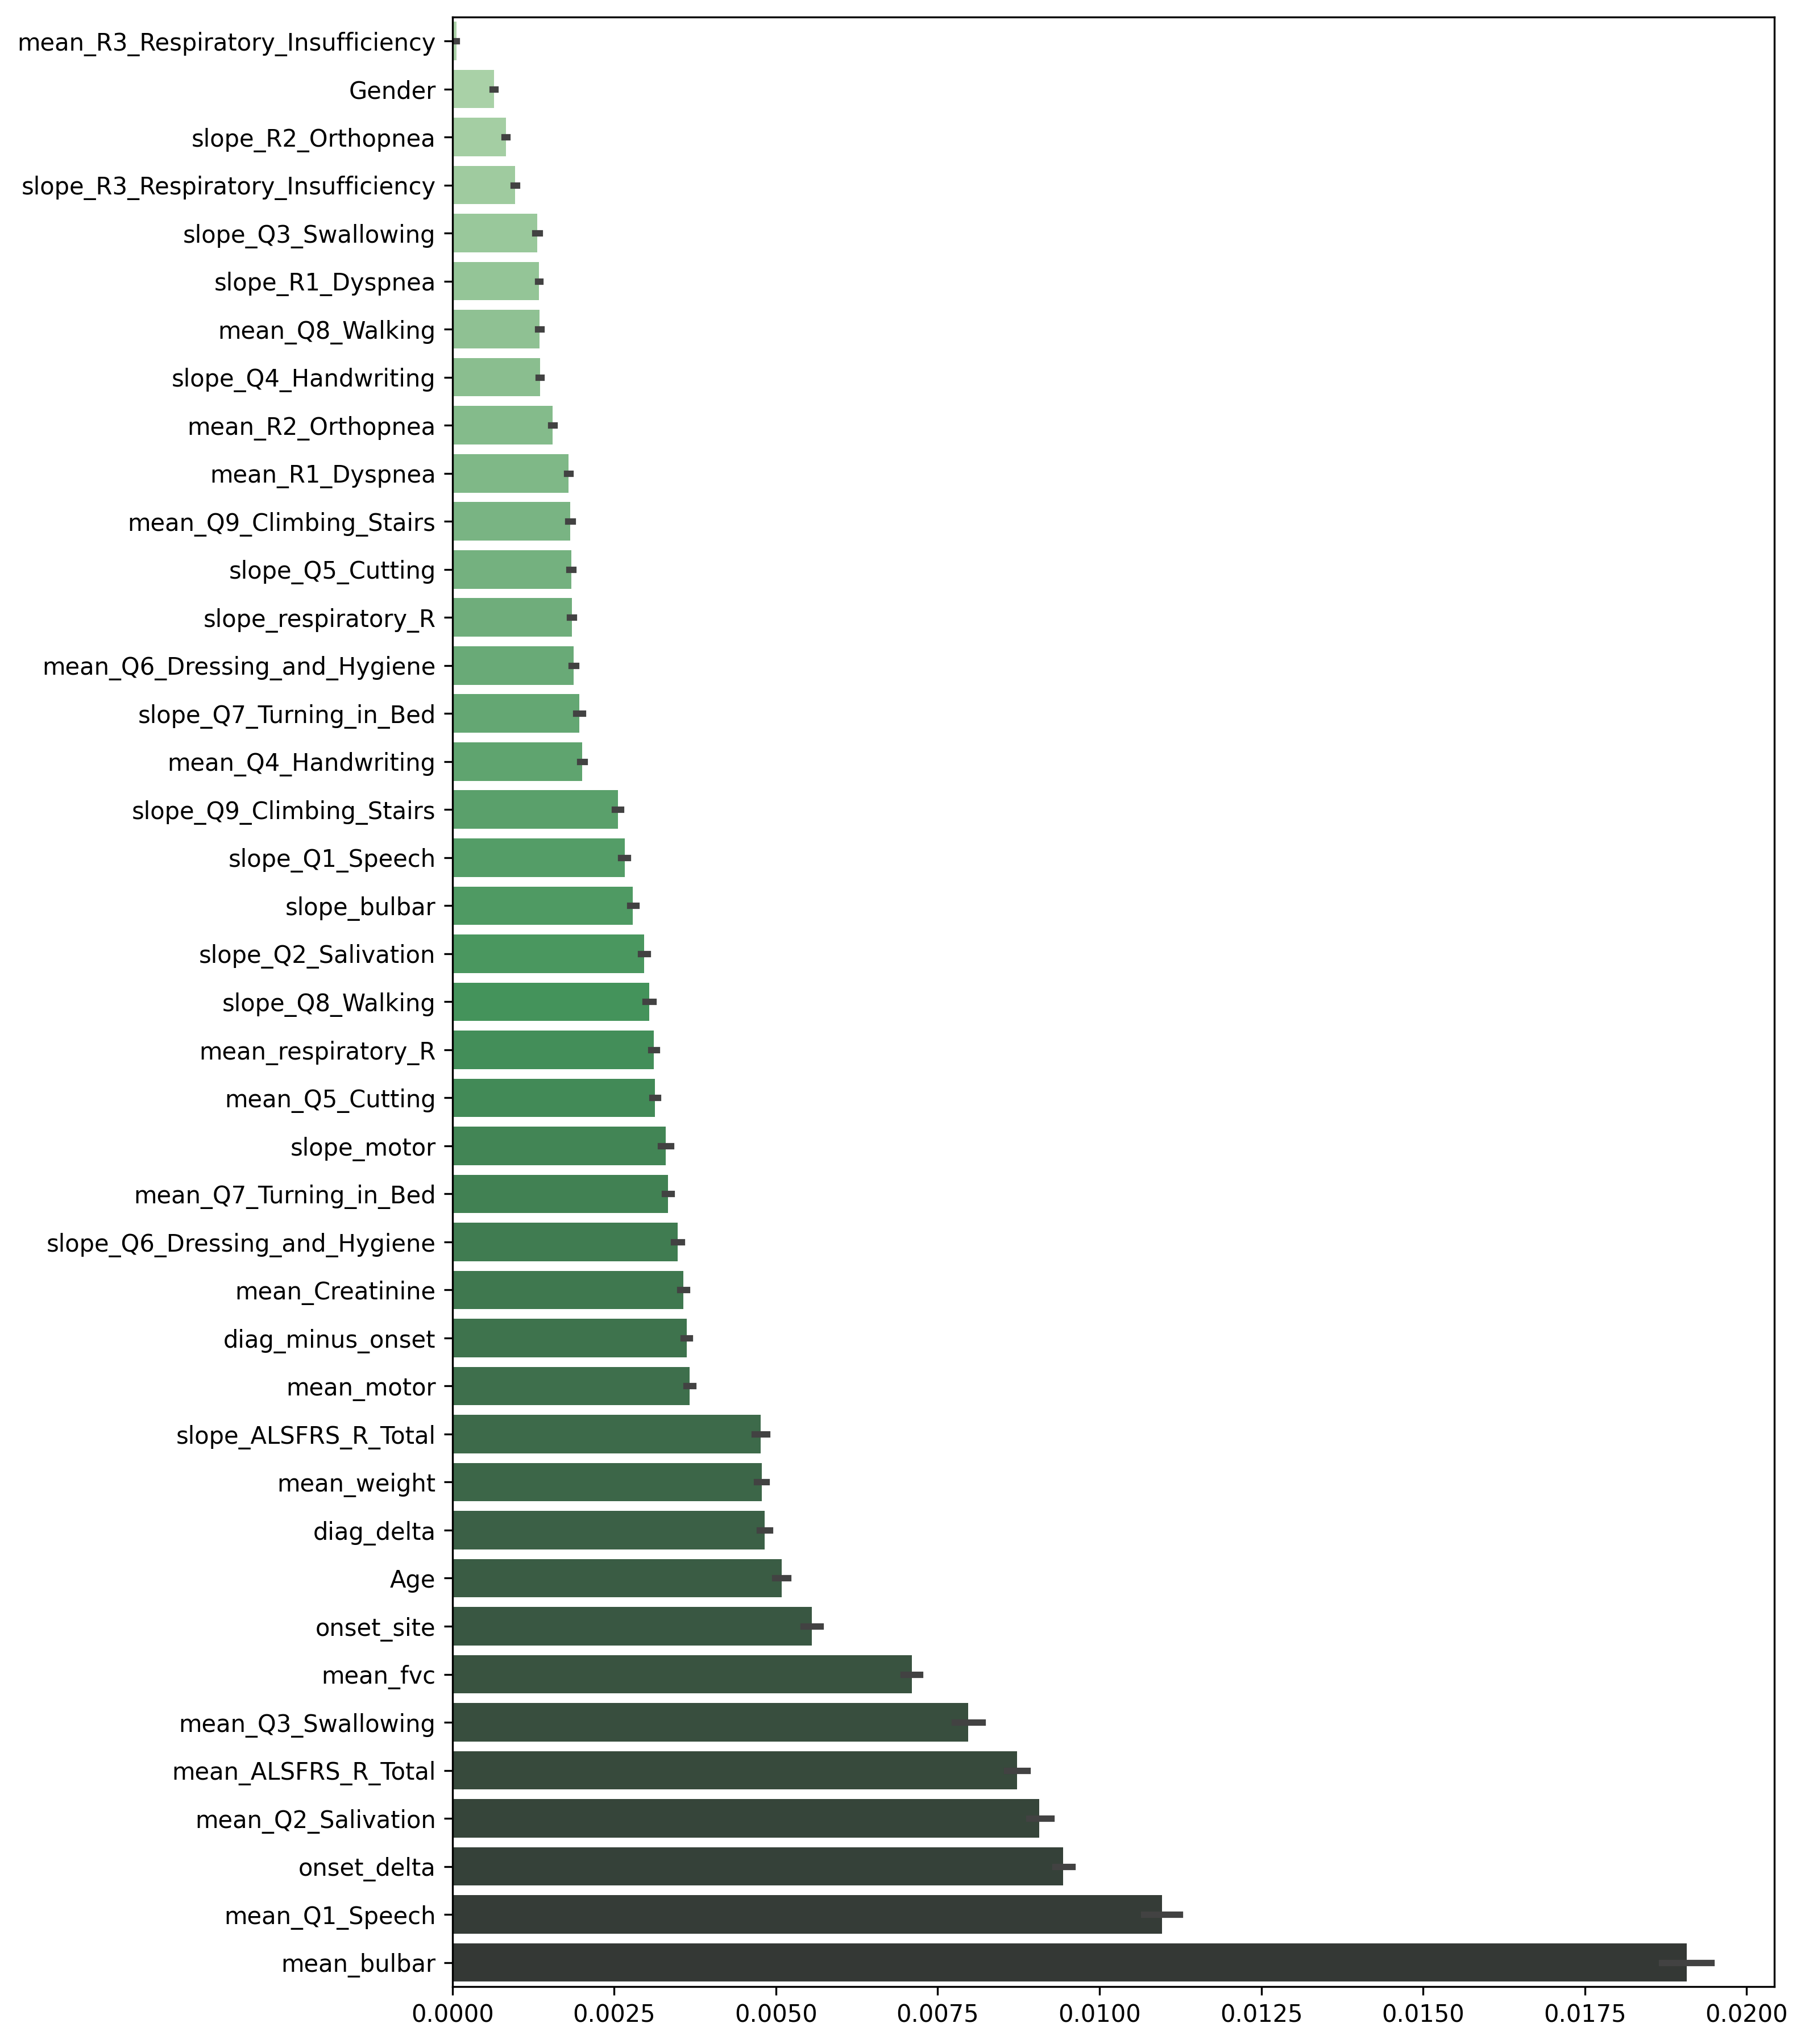

In [ ]:
data = perm.results_
df = pd.DataFrame(data, columns=rsf_feature_list)
df_sorted = df.reindex(df.mean().sort_values().index, axis=1)

# Plot the data and the 95% CI intervals as error bars
plt.figure(figsize=(10, 15))
sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )
plt.show()

<ipython-input-24-7b2508b09056>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )


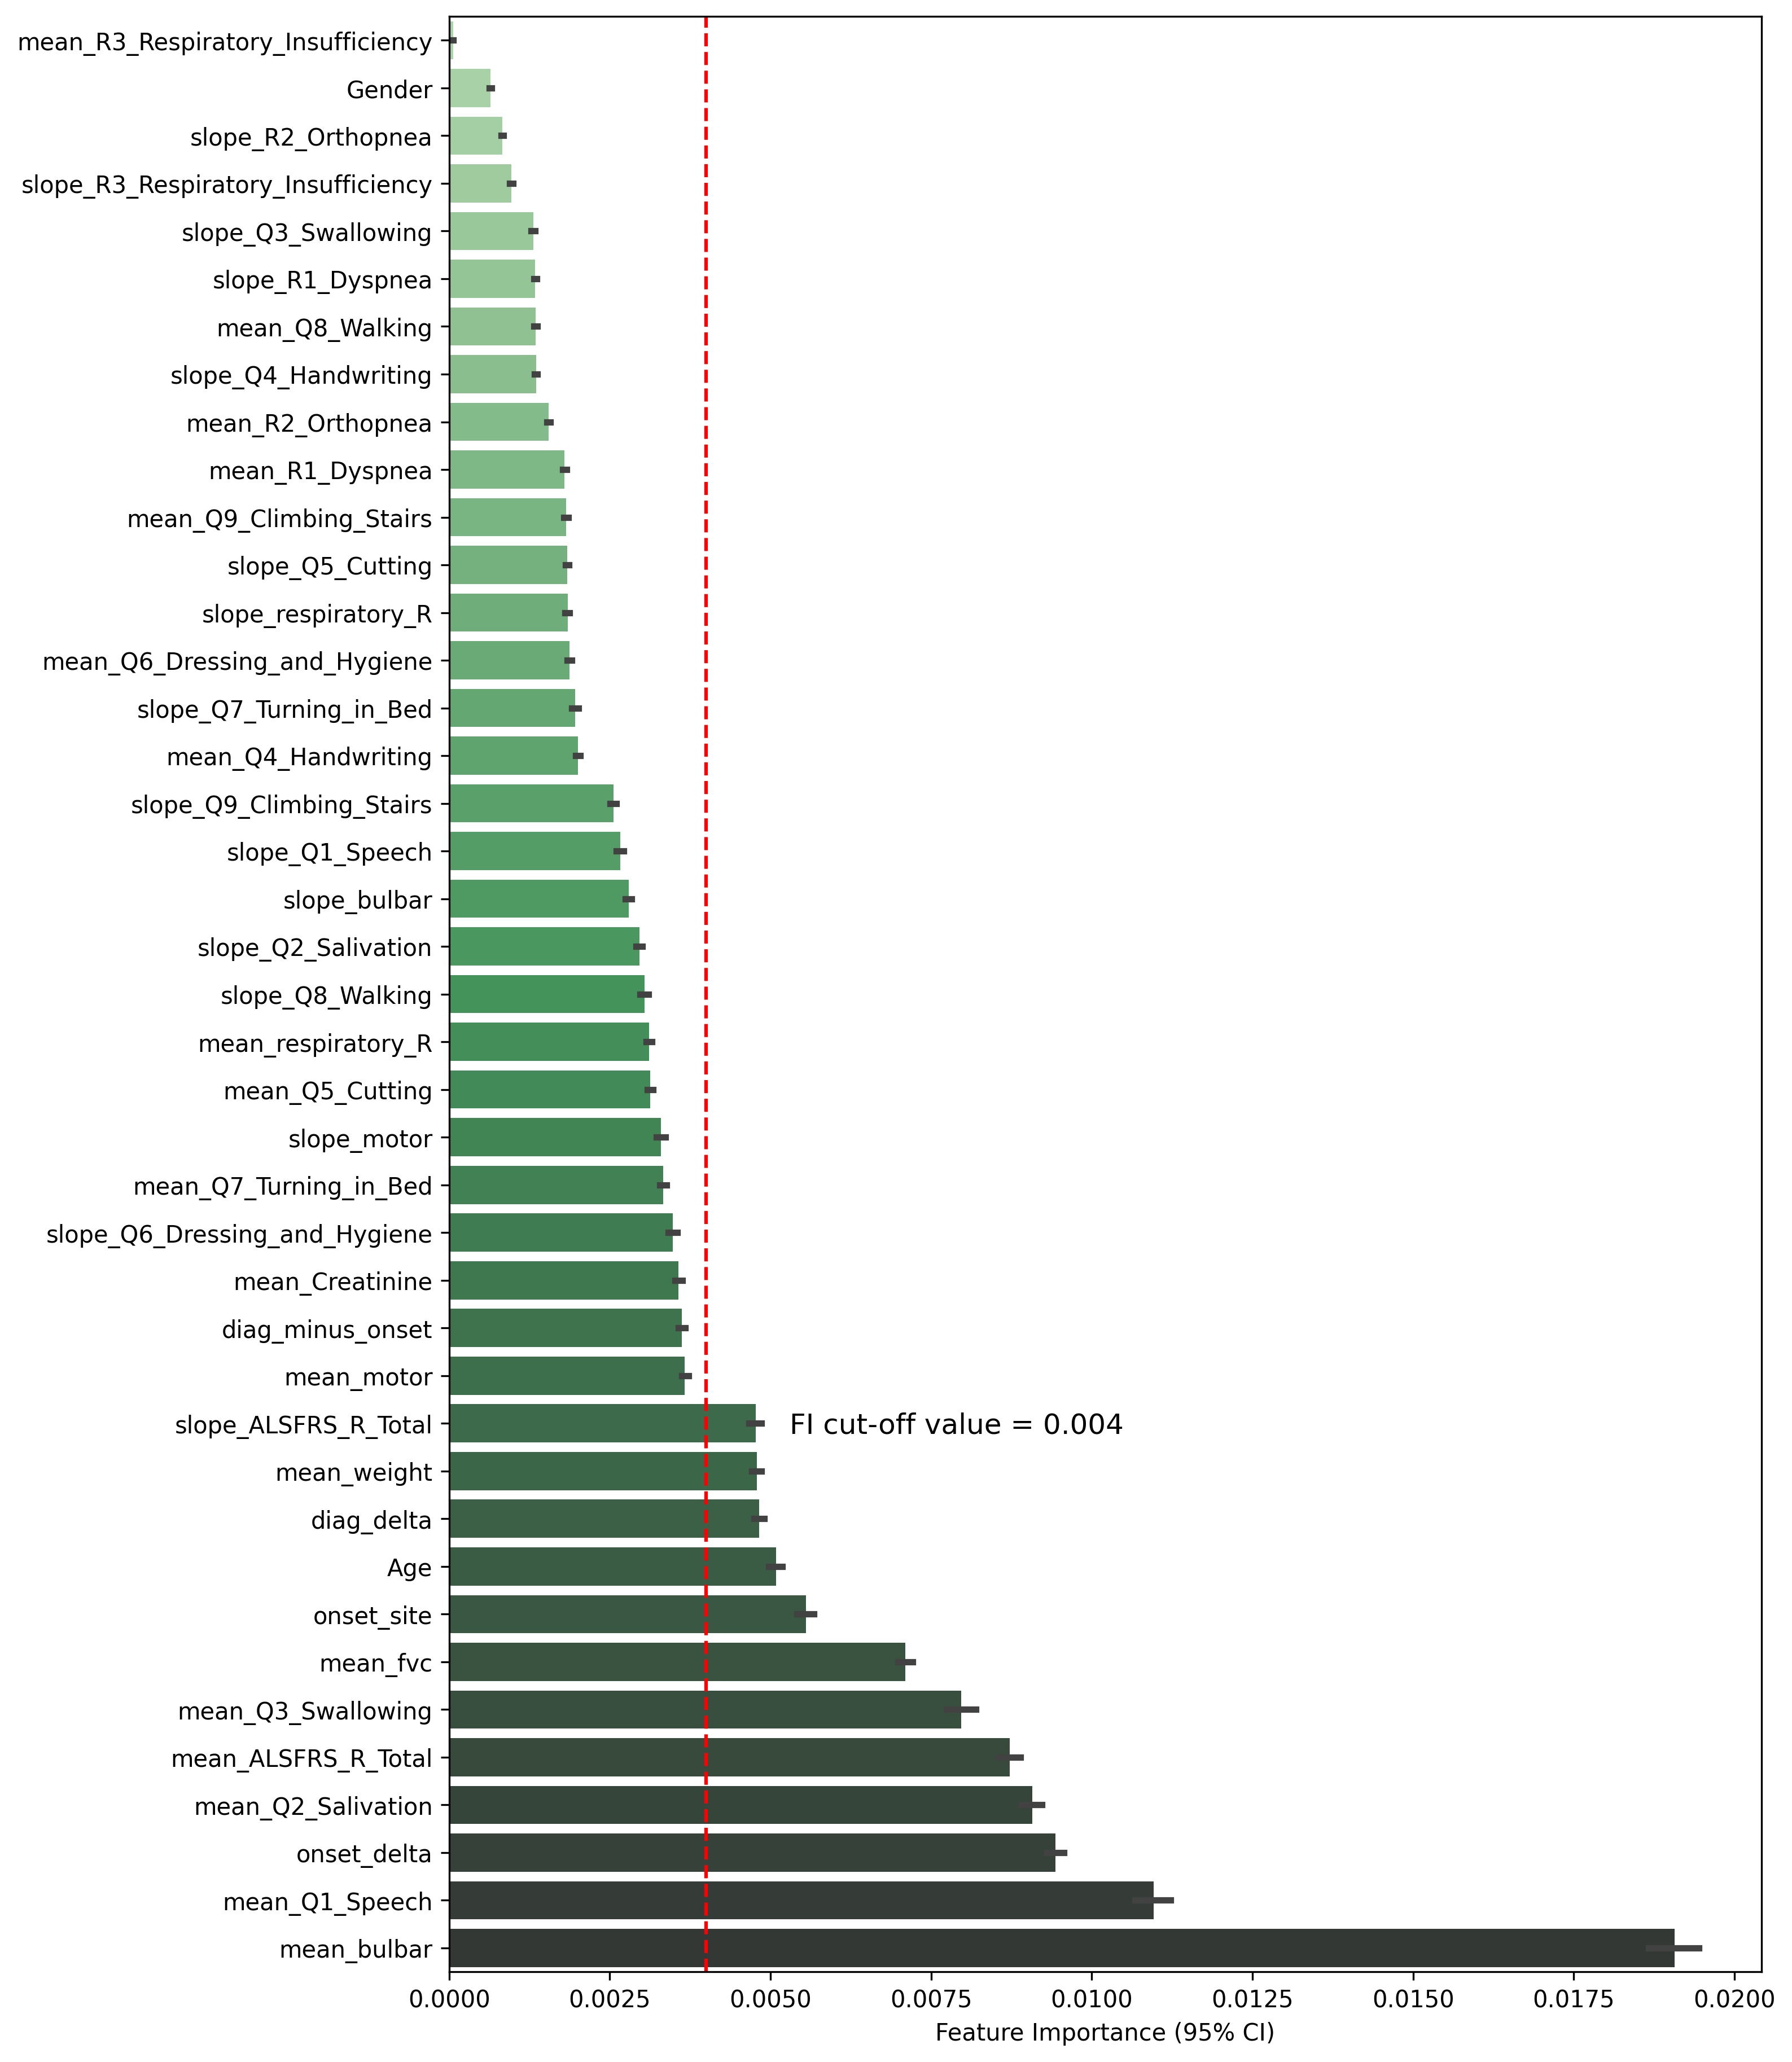

In [ ]:
# Plot the data and the 95% CI intervals as error bars
plt.figure(figsize=(10, 15))
sns.barplot(data=df_sorted, ci=95, orient='h', palette='Greens_d' )

plt.axvline(x=0.004, color='red', linestyle='--')
plt.annotate('FI cut-off value = 0.004', xy=(0.0053, 29.2), color='k', fontsize=12)
plt.xlabel('Feature Importance (95% CI)')

plt.show()

In [ ]:
#Calculate mean, std
mean = df_sorted.mean()
std = df_sorted.std()

# Calculate the 95% confidence intervals by group
interval = 1.96 * std / np.sqrt(len(df_sorted))

# Calculate the lower 95% CI
lower_95_CI = mean - interval
lower_95_CI

mean_R3_Respiratory_Insufficiency     0.000058
Gender                                0.000622
slope_R2_Orthopnea                    0.000805
slope_R3_Respiratory_Insufficiency    0.000946
slope_Q3_Swallowing                   0.001278
slope_R1_Dyspnea                      0.001319
mean_Q8_Walking                       0.001320
slope_Q4_Handwriting                  0.001330
mean_R2_Orthopnea                     0.001519
mean_R1_Dyspnea                       0.001770
mean_Q9_Climbing_Stairs               0.001787
slope_Q5_Cutting                      0.001805
slope_respiratory_R                   0.001810
mean_Q6_Dressing_and_Hygiene          0.001841
slope_Q7_Turning_in_Bed               0.001911
mean_Q4_Handwriting                   0.001968
slope_Q9_Climbing_Stairs              0.002506
slope_Q1_Speech                       0.002603
slope_bulbar                          0.002743
slope_Q2_Salivation                   0.002909
slope_Q8_Walking                      0.002977
mean_respirat

In [ ]:
# feature selected based on permutation importance (lower 95% CI > 0.004)
rsf_final_feature_list = lower_95_CI[lower_95_CI>0.004].index.tolist()

print("Total " + str(len(rsf_final_feature_list)) + " features are selected through permutation importance in RSF")
print(rsf_final_feature_list)

Total 12 features are selected through permutation importance in RSF
['slope_ALSFRS_R_Total', 'mean_weight', 'diag_delta', 'Age', 'onset_site', 'mean_fvc', 'mean_Q3_Swallowing', 'mean_ALSFRS_R_Total', 'mean_Q2_Salivation', 'onset_delta', 'mean_Q1_Speech', 'mean_bulbar']


# 3. Finalize feature selection

In [ ]:
from matplotlib_venn import venn3_unweighted

In [ ]:
#Feature selection results
aft_final_feature_list = ['onset_site', 'Age', 'mean_R3_Respiratory_Insufficiency', 'slope_ALSFRS_R_Total',
                          'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'slope_Q2_Salivation',
                          'slope_R3_Respiratory_Insufficiency', 'slope_Q8_Walking', 'slope_Q1_Speech',
                          'mean_Q3_Swallowing', 'slope_Q6_Dressing_and_Hygiene', 'mean_bulbar']

cph_final_feature_list = ['mean_bulbar', 'slope_Q6_Dressing_and_Hygiene', 'mean_Q3_Swallowing', 'slope_Q1_Speech',
                          'slope_Q2_Salivation', 'slope_Q8_Walking', 'mean_Q2_Salivation', 'slope_ALSFRS_R_Total',
                          'mean_Q7_Turning_in_Bed', 'mean_R3_Respiratory_Insufficiency', 'Age', 'onset_site']

rsf_final_feature_list = ['slope_ALSFRS_R_Total', 'mean_weight', 'diag_delta', 'Age', 'onset_site', 'mean_fvc',
                          'mean_Q3_Swallowing', 'mean_ALSFRS_R_Total', 'mean_Q2_Salivation', 'onset_delta',
                          'mean_Q1_Speech', 'mean_bulbar']

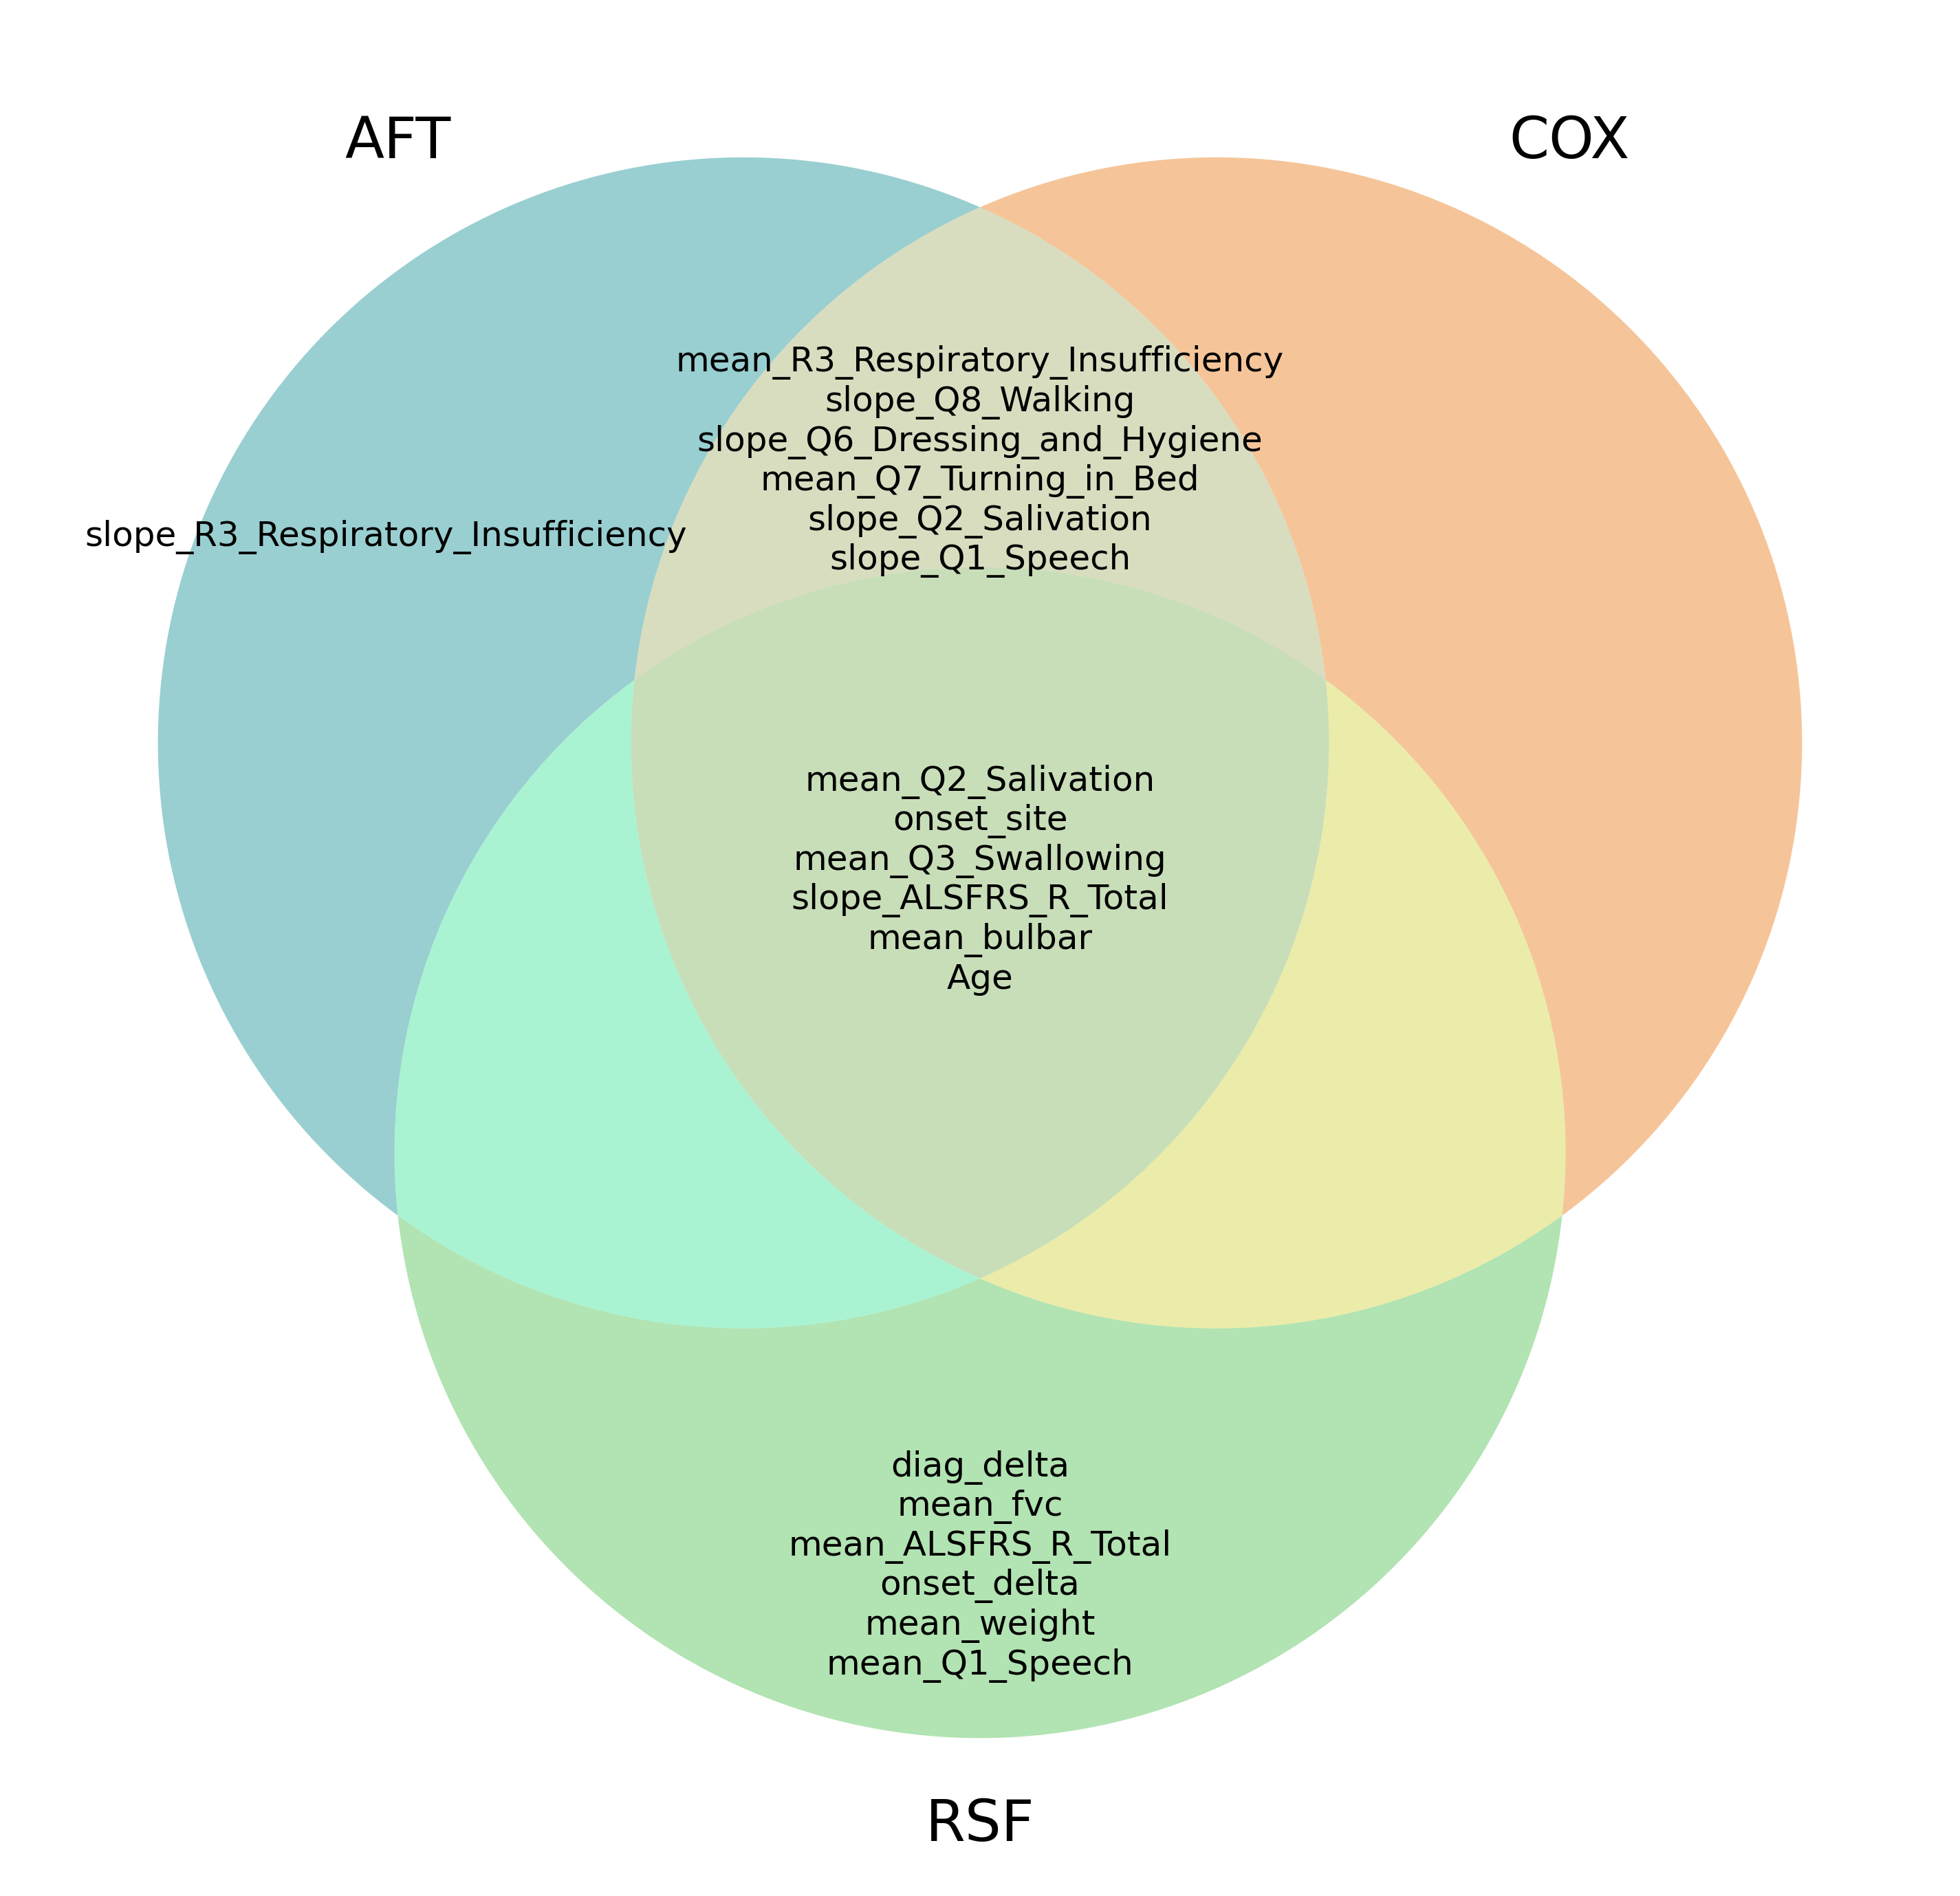

<Figure size 7500x7500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted

# Define 2 sets
A = set(aft_final_feature_list)
B = set(cph_final_feature_list)
C = set(rsf_final_feature_list)

# Create and instance of a venn diagram with 2 areas
plt.figure(figsize=(12,12))
diagram = venn3_unweighted([A, B, C], ("AFT", "COX", "RSF") ,set_colors= ('#00878E', '#E86E00', '#3FBB3F'))

# Set text content of areas
diagram.get_label_by_id("100").set_text("\n".join(A - B - C))
diagram.get_label_by_id("010").set_text("\n".join(B - A - C))
diagram.get_label_by_id("001").set_text("\n".join(C - B - A))
diagram.get_label_by_id("110").set_text("\n".join(A & B - C))
diagram.get_label_by_id("101").set_text("\n".join(A & C - B))
diagram.get_label_by_id("011").set_text("\n".join(C & B - A))
diagram.get_label_by_id("111").set_text("\n".join(A & B & C))

# Modify font sizes
for text in diagram.set_labels:
    text.set_fontsize(20)
for text in diagram.subset_labels:
    text.set_fontsize(12)

plt.figure(figsize=(25,25))
plt.show()